## [Import data]

In [1]:
!pip install pandas==2.2.1

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pandas==2.2.1
numpy==1.26.4
seaborn==0.13.2


In [3]:
TRAIN_INPUT = "../data/x_train.csv"
TRAIN_OUTPUT = "../data/y_train.csv"
TEST_INPUT = "../data/x_test.csv"

In [4]:
x_train = pd.read_csv(TRAIN_INPUT, index_col= 'DELIVERY_START', parse_dates=True)
y_train = pd.read_csv(TRAIN_OUTPUT, index_col= 'DELIVERY_START', parse_dates=True)
x_test = pd.read_csv(TEST_INPUT, index_col= 'DELIVERY_START', parse_dates=True)

In [5]:
#datetime data
x_train.set_index(pd.to_datetime(x_train.index, utc=True), inplace=True)
y_train.set_index(pd.to_datetime(y_train.index, utc=True), inplace=True)
x_test.set_index(pd.to_datetime(x_test.index, utc=True), inplace=True)

# Summary
1. Samples are not all 1Hour-spaced
2. ~~Datetime column not in same timezone~~ --> Solved above using ``utc=True`` in the cell above
3. Data is balanced for classification 50% positive labels /50% negative labels
4. **Missing values** : most of values from column 'predicted_spot_price', and big chunk of data in 'load_forecast' missing during summer months of 2022
5. High **correlations** between : 
    * nuclear_power_available and coal_power_available
    * nuclear_power_available and load_forecast
6. **outliers**
---

# Detail

In [6]:
print(f"Training data : from {x_train.index.min()} to {x_train.index.max()}")
print(f"Test data : from {x_test.index.min()} to {x_test.index.max()}")

Training data : from 2022-01-01 01:00:00+00:00 to 2023-03-29 21:00:00+00:00
Test data : from 2023-04-01 22:00:00+00:00 to 2023-10-24 21:00:00+00:00


## 1. Sampling frequency : heterogeneous

In [7]:
x_train.index.diff().dropna().total_seconds().value_counts()

DELIVERY_START
3600.0      10595
90000.0         4
144000.0        1
43200.0         1
165600.0        1
262800.0        1
7200.0          1
Name: count, dtype: int64

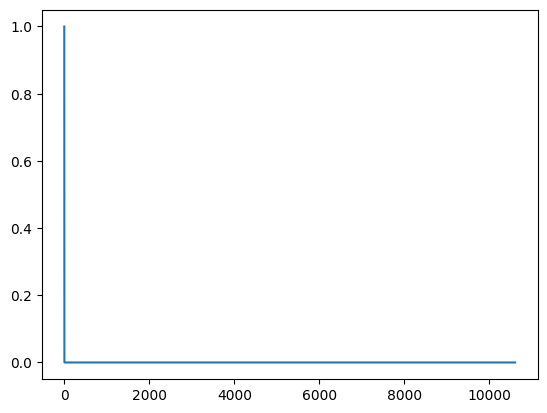

In [8]:
plt.plot(x_train.index.diff().isna().astype(int))

In [9]:
x_test.index.diff().dropna().total_seconds().value_counts()

DELIVERY_START
3600.0     4940
10800.0       1
Name: count, dtype: int64

In [10]:
differences = x_train.index.diff().total_seconds()/3600
indices = np.where(pd.Series(index=x_train.index,data=differences)>1.0)[0]
x_train.index[indices]
previous = list(map(lambda x:x-1, indices))
data = [(x_train.index[previous[i]],x_train.index[indices[i]],differences[indices[i]]) for i in range(len(indices))]
diff_spacings_train = pd.DataFrame(data, columns=['n-1','n','timedelta (hours)'])
diff_spacings_train

n-1                         n  timedelta (hours)
0 2022-02-12 22:00:00+00:00 2022-02-14 14:00:00+00:00               40.0
1 2022-03-29 21:00:00+00:00 2022-03-30 09:00:00+00:00               12.0
2 2022-03-30 09:00:00+00:00 2022-04-01 07:00:00+00:00               46.0
3 2022-05-28 21:00:00+00:00 2022-05-29 22:00:00+00:00               25.0
4 2022-06-10 21:00:00+00:00 2022-06-11 22:00:00+00:00               25.0
5 2022-06-15 21:00:00+00:00 2022-06-16 22:00:00+00:00               25.0
6 2022-09-13 21:00:00+00:00 2022-09-16 22:00:00+00:00               73.0
7 2022-10-30 00:00:00+00:00 2022-10-30 02:00:00+00:00                2.0
8 2023-02-23 22:00:00+00:00 2023-02-24 23:00:00+00:00               25.0

In [11]:
differences = x_test.index.diff().total_seconds()/3600
indices = np.where(pd.Series(index=x_test.index,data=differences)>1.0)[0]
x_test.index[indices]
previous = list(map(lambda x:x-1, indices))
data = [(x_test.index[previous[i]],x_test.index[indices[i]],differences[indices[i]]) for i in range(len(indices))]
diff_spacings_test = pd.DataFrame(data, columns=['n-1','n','timedelta (hours)'])
diff_spacings_test

n-1                         n  timedelta (hours)
0 2023-05-07 21:00:00+00:00 2023-05-08 00:00:00+00:00                3.0

In [12]:
x_train.index.inferred_freq

In [13]:
x_train['load_forecast']['2022-01'].index.inferred_freq

'h'

## 2. Is data balanced across classification labels

In [14]:
y_train_cls = (y_train>0).astype(int)
100*y_train_cls.value_counts()/y_train.shape[0]

spot_id_delta
1                50.165017
0                49.834983
Name: count, dtype: float64

## 3. Missing Values

In [15]:
x_train.isna().sum()/x_train.shape[0]*100

load_forecast                    12.135785
coal_power_available              0.009430
gas_power_available               0.009430
nucelear_power_available          0.009430
wind_power_forecasts_average      0.226308
solar_power_forecasts_average     0.226308
wind_power_forecasts_std          0.226308
solar_power_forecasts_std         0.226308
predicted_spot_price             82.593116
dtype: float64

Text(0.5, 1.0, 'TRAIN SET MISSING VALUES')

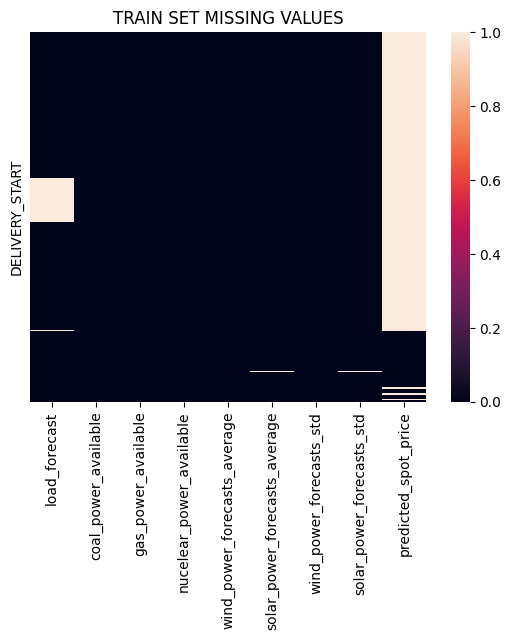

In [16]:
sns.heatmap(x_train.isna(),xticklabels='auto', yticklabels=False)
plt.title('TRAIN SET MISSING VALUES')

In [17]:
x_test.isna().sum()

load_forecast                       0
coal_power_available                0
gas_power_available                 0
nucelear_power_available            0
wind_power_forecasts_average        0
solar_power_forecasts_average      24
wind_power_forecasts_std            0
solar_power_forecasts_std          24
predicted_spot_price             1536
dtype: int64

Text(0.5, 1.0, 'TEST SET MISSING VALUES')

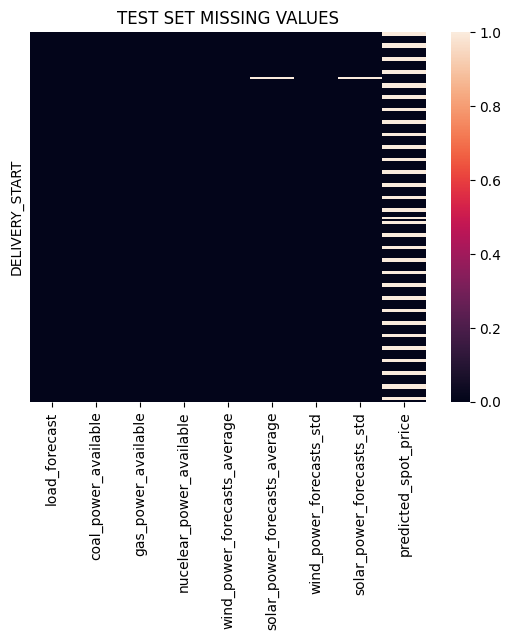

In [18]:
sns.heatmap(x_test.isna(), yticklabels=False)
plt.title('TEST SET MISSING VALUES')

## 4. Feature distributions

<Axes: ylabel='Count'>

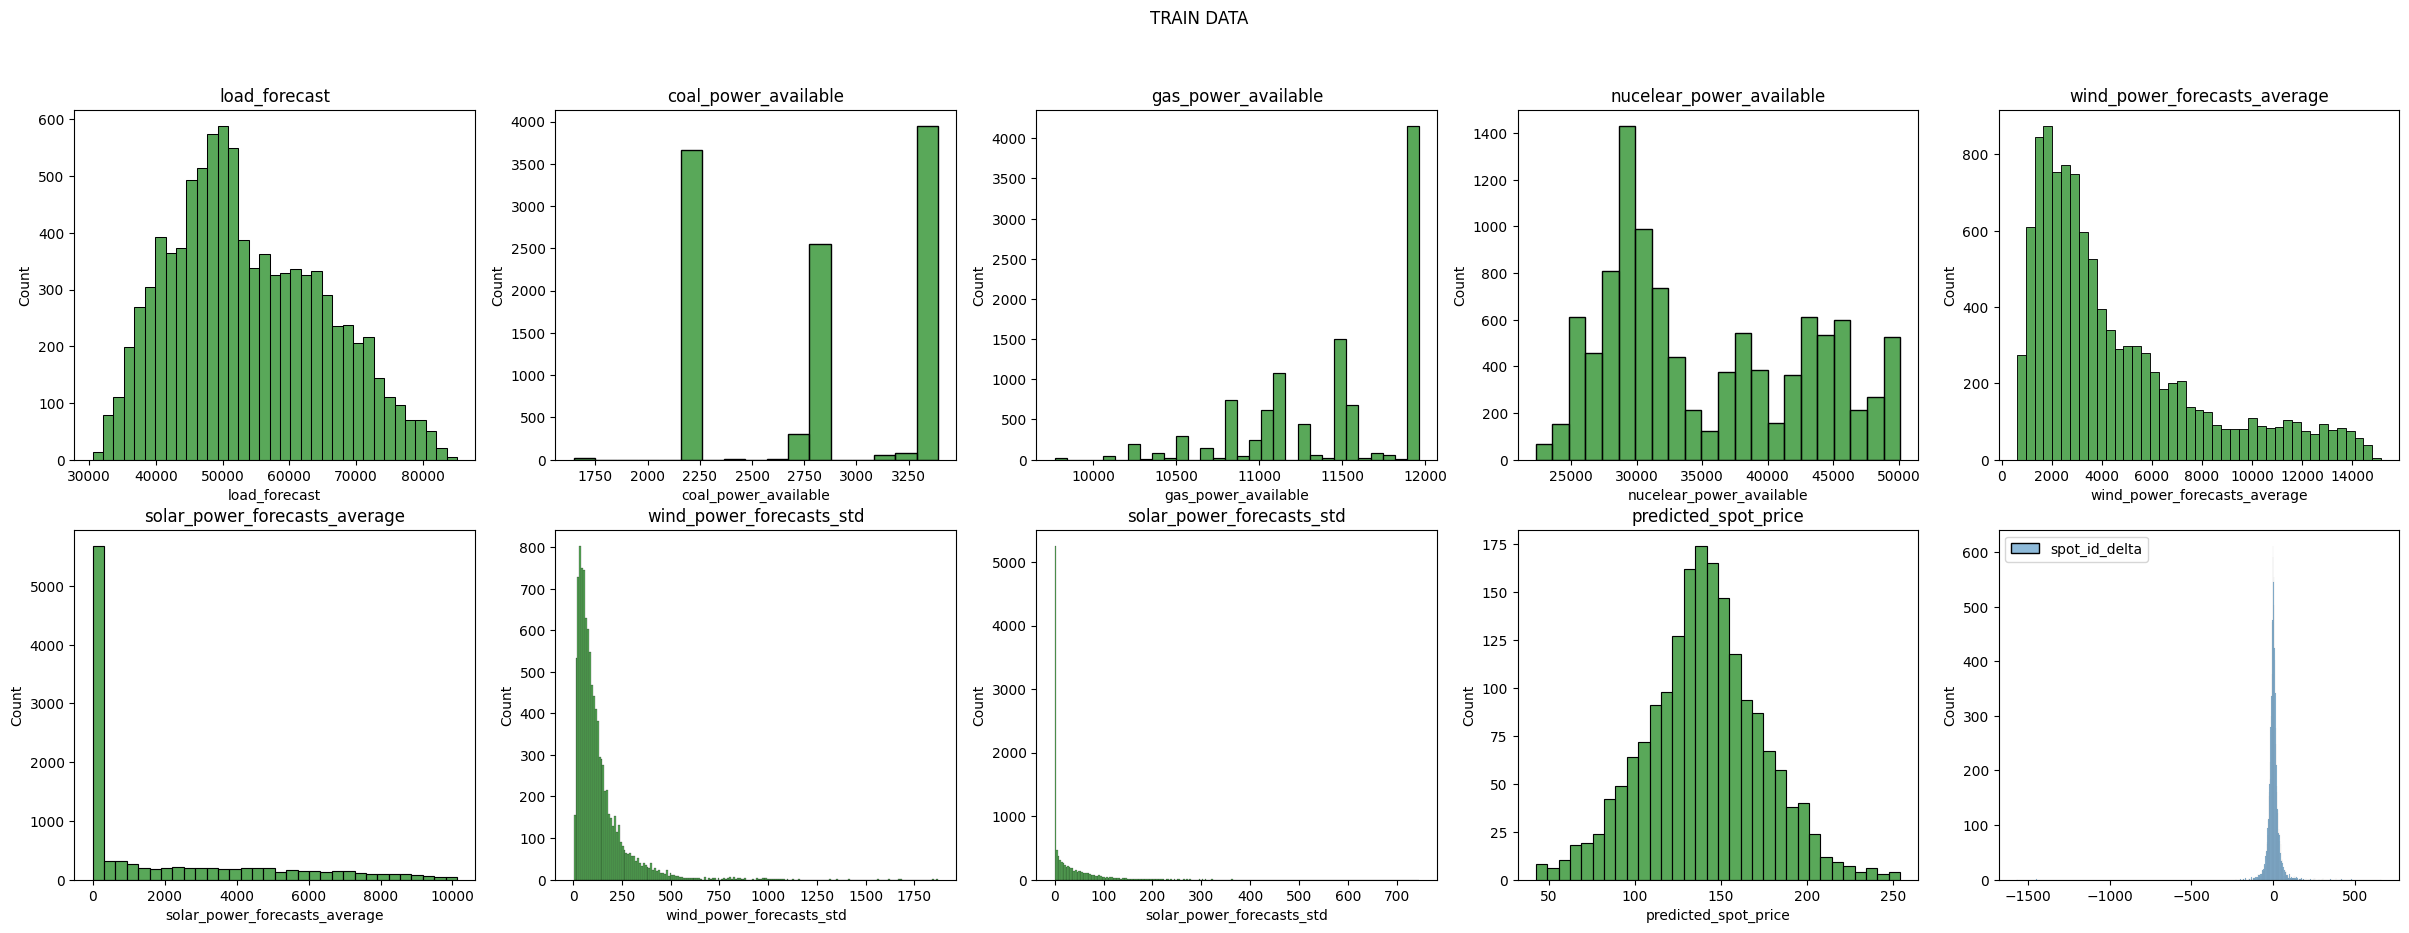

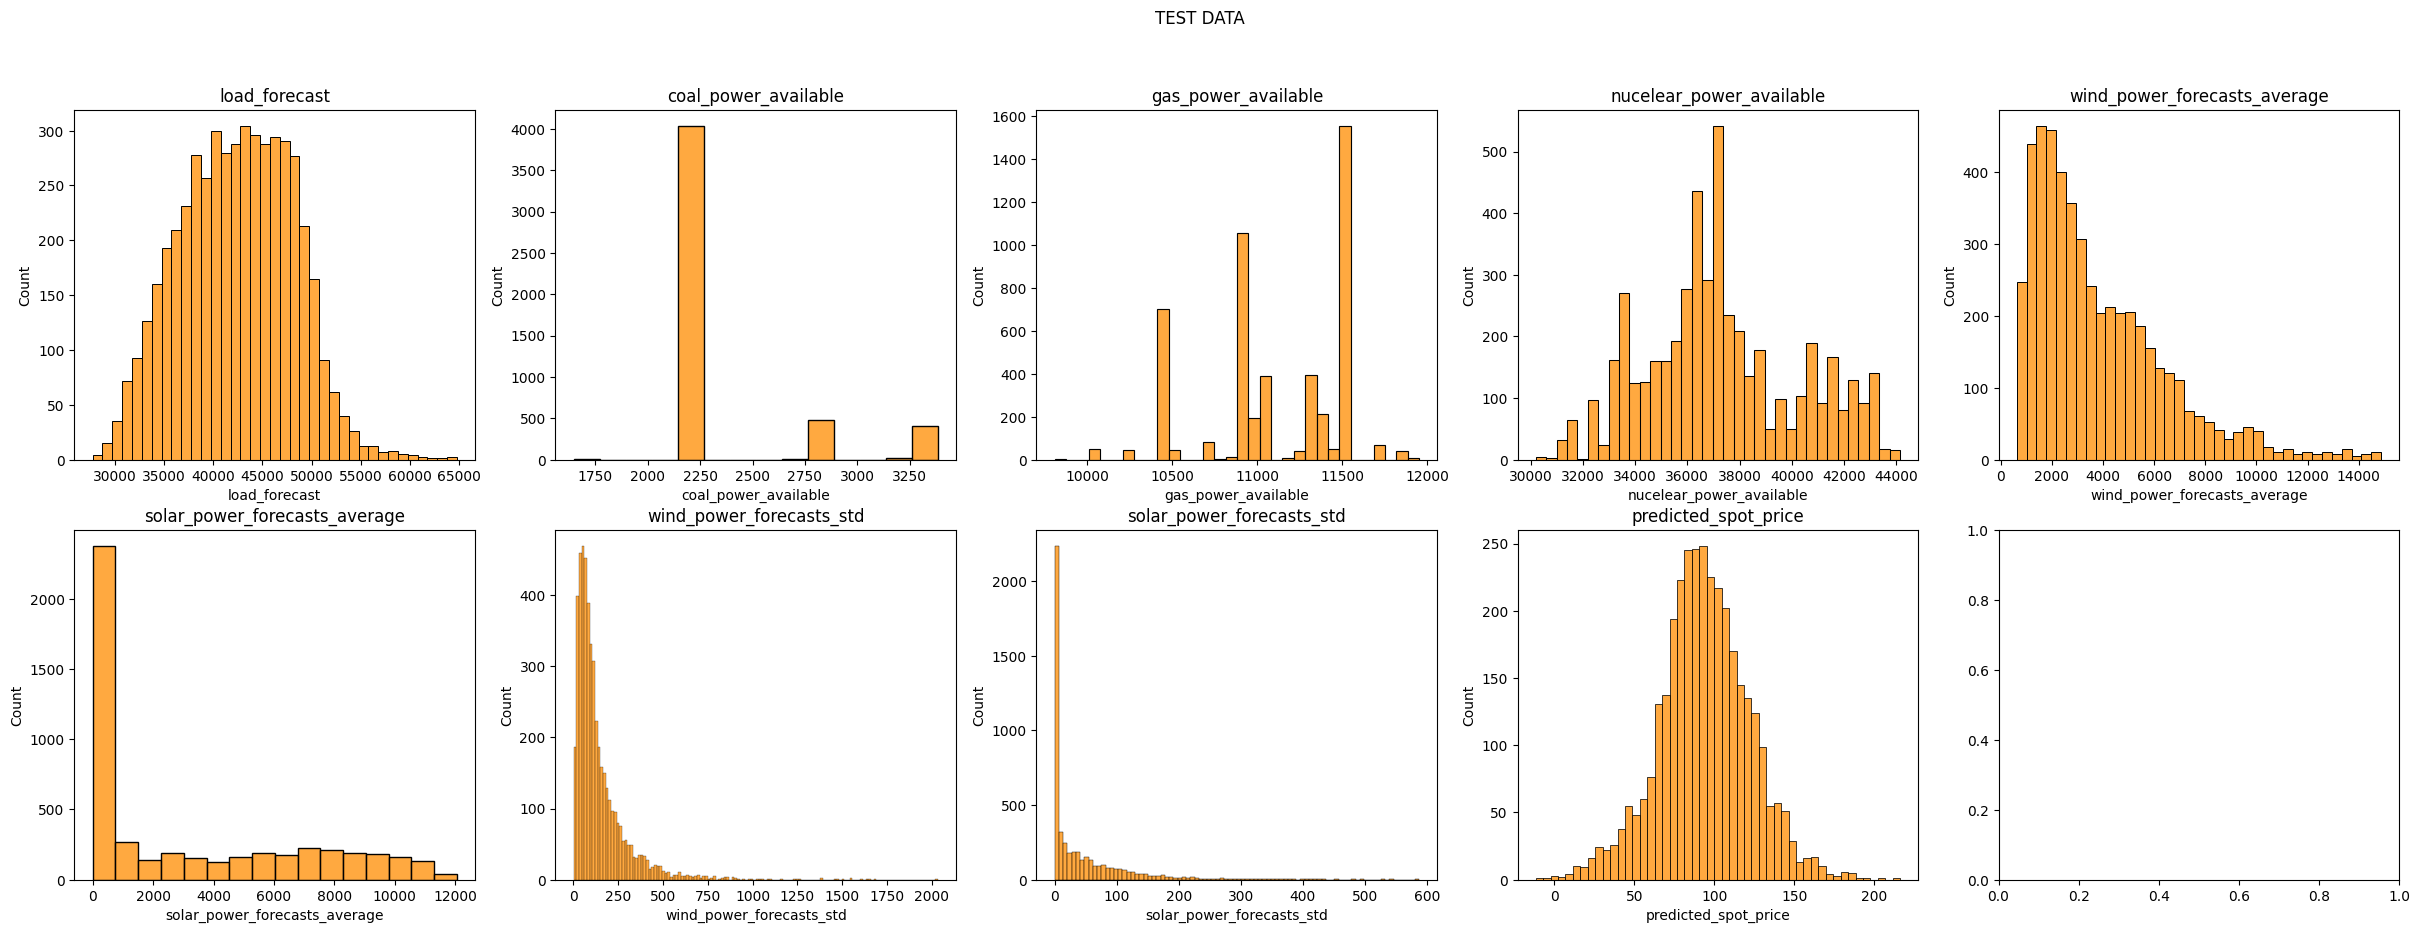

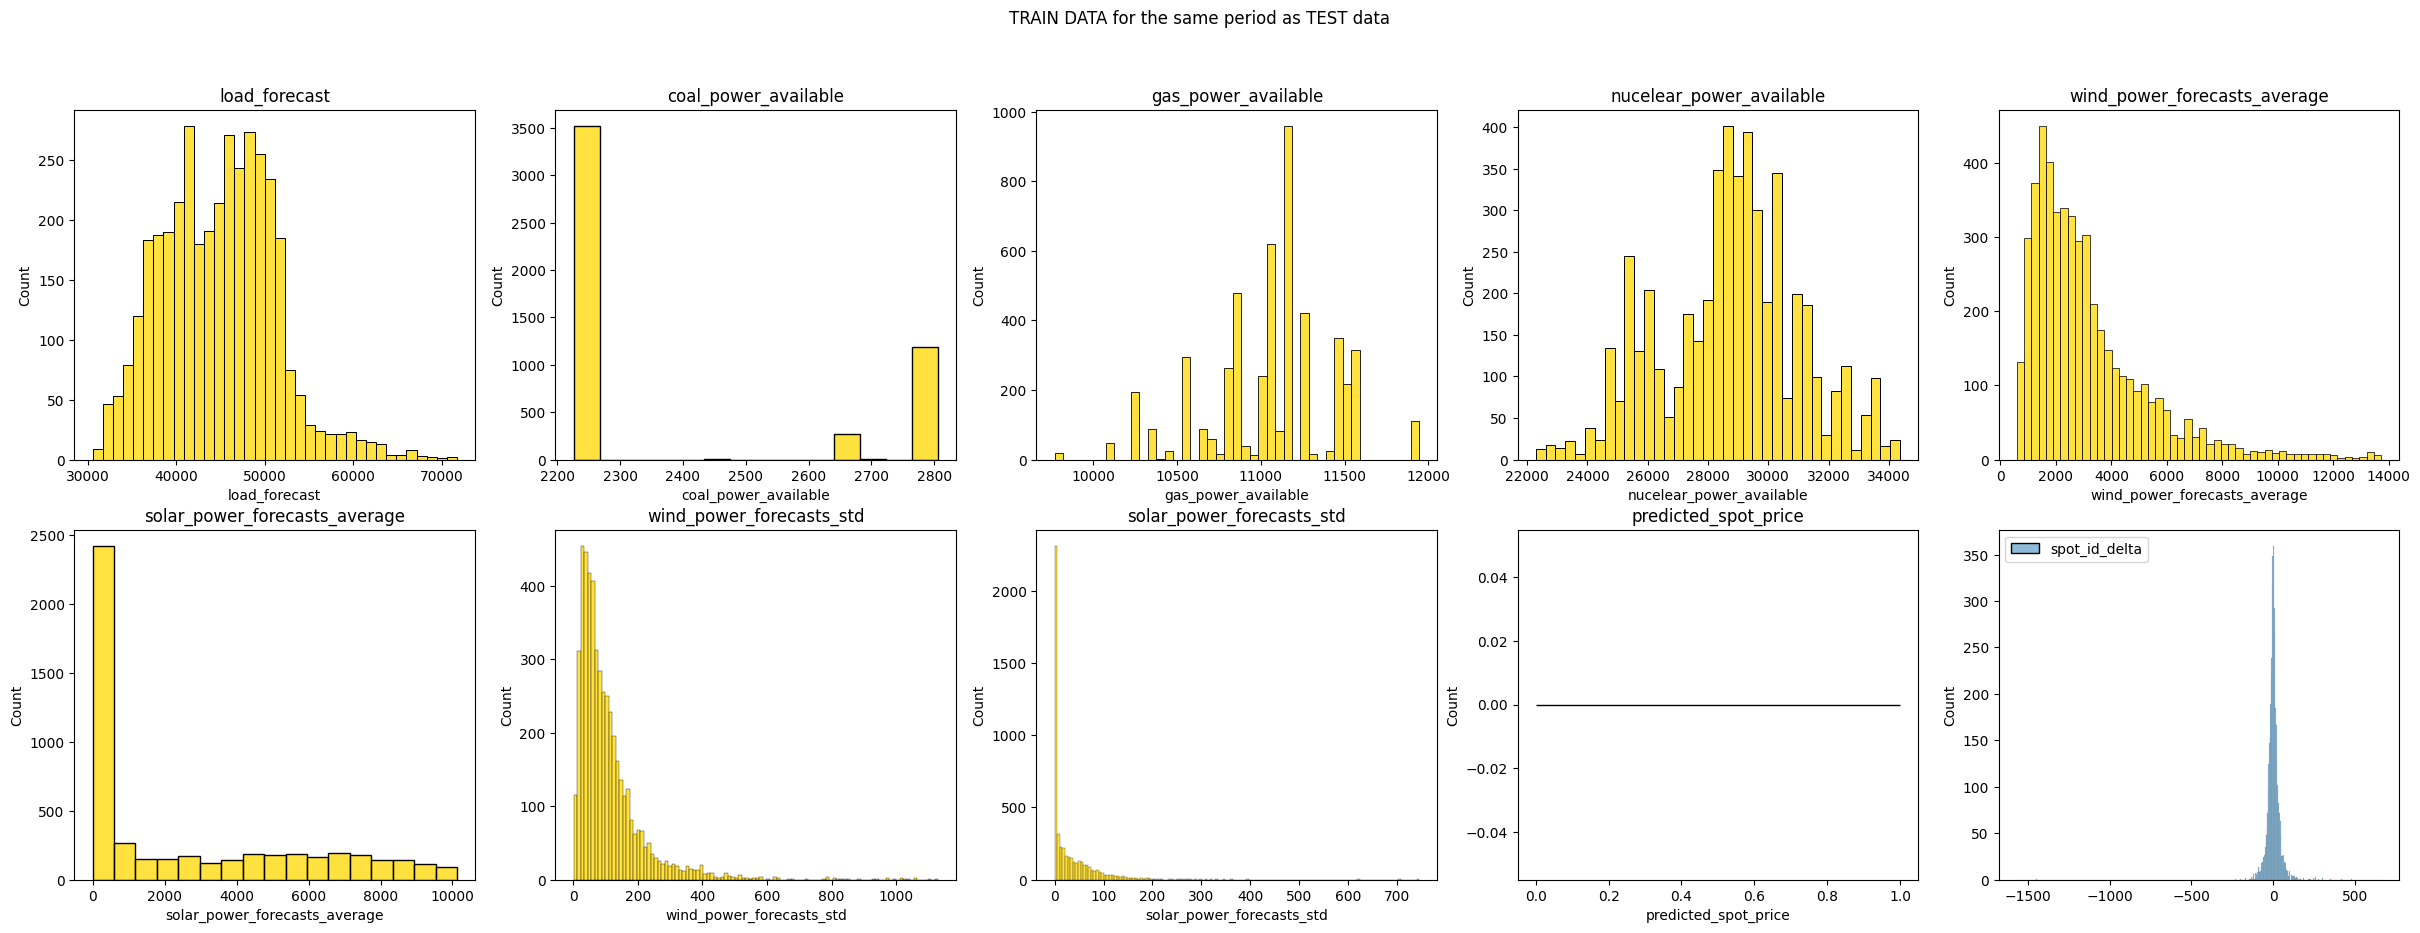

In [19]:
fig, axes = plt.subplots(nrows = 2, ncols = 5)    # axes is 2d array (3x3)
axes = axes.flatten()         # Convert axes to 1d array of length 9
fig.set_size_inches(30, 10)
fig.suptitle('TRAIN DATA')


for ax, col in zip(axes, x_train.columns):
  sns.histplot(x_train[col], ax = ax, color='forestgreen')
  ax.set_title(col)
sns.histplot(y_train, ax = axes[-1], color='forestgreen')

fig, axes = plt.subplots(nrows = 2, ncols = 5)    # axes is 2d array (3x3)
axes = axes.flatten()         # Convert axes to 1d array of length 9
fig.set_size_inches(30, 10)
fig.suptitle('TEST DATA')

for ax, col in zip(axes, x_test.columns):
  sns.histplot(x_test[col], ax = ax, color='darkorange')
  ax.set_title(col)

fig, axes = plt.subplots(nrows = 2, ncols = 5)    # axes is 2d array (3x3)
axes = axes.flatten()         # Convert axes to 1d array of length 9
fig.set_size_inches(30, 10)
fig.suptitle('TRAIN DATA for the same period as TEST data')

for ax, col in zip(axes, x_train.columns):
  sns.histplot(x_train['2022-04':'2022-10'][col], ax = ax, color='gold')
  ax.set_title(col)
sns.histplot(y_train['2022-04':'2022-10'], ax = axes[-1], color='gold')

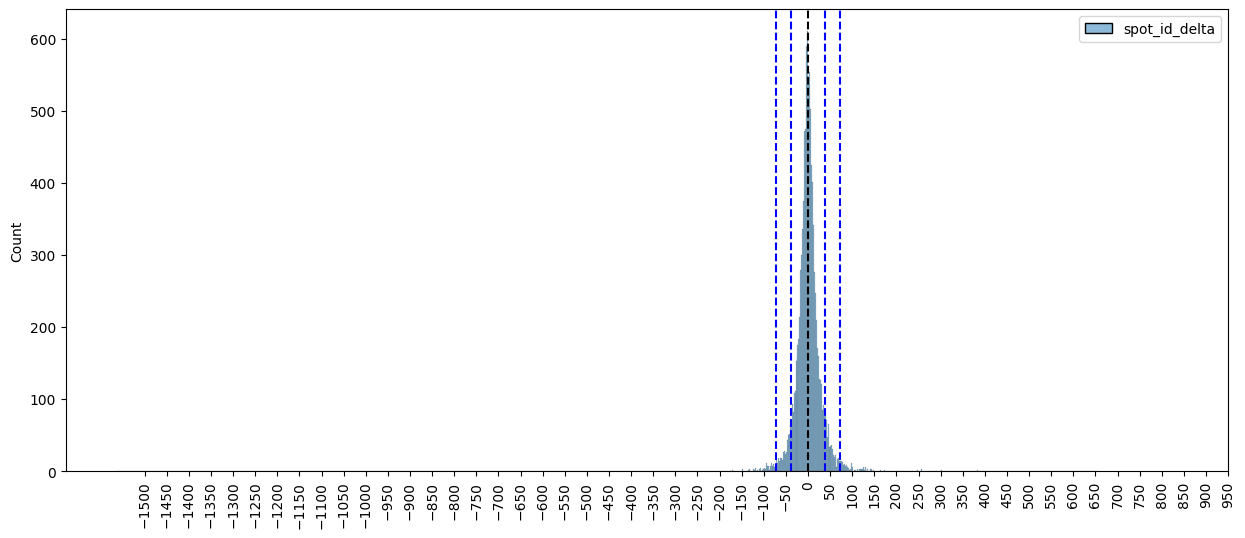

In [20]:
plt.figure(figsize=(15,6))
sns.histplot(y_train, color='forestgreen')
plt.xticks(np.arange(-1500,1000,50),rotation='vertical')
plt.axvline(0, linestyle='--',color='black')
plt.axvline(38, linestyle='--',color='blue')
plt.axvline(72, linestyle='--',color='blue')
plt.axvline(-38, linestyle='--',color='blue')
plt.axvline(-72, linestyle='--',color='blue')


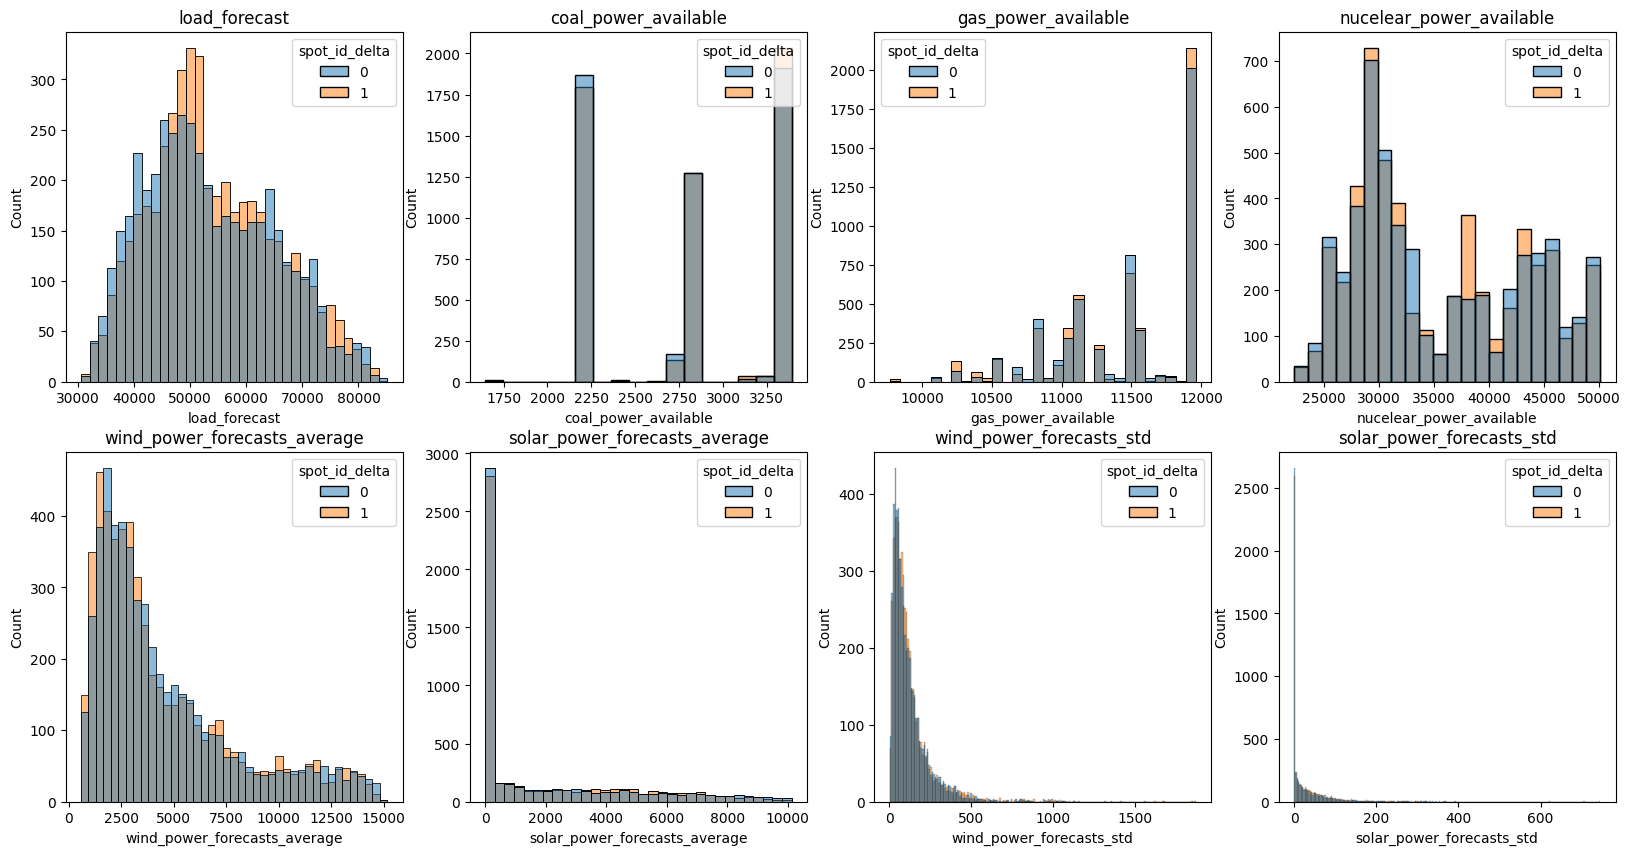

In [38]:
data = pd.concat([x_train,y_train_cls],axis=1)
fig, axes = plt.subplots(nrows = 2, ncols = 4)    # axes is 2d array (3x3)
axes = axes.flatten()         # Convert axes to 1d array of length 9
fig.set_size_inches(20, 10)

for ax, col in zip(axes, x_train.columns):
  sns.histplot(data=data, x=col, ax = ax, color='forestgreen', hue ='spot_id_delta')
  ax.set_title(col)


## Target variable

(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([ 0.01645183, -0.04365145,  0.00885791,  0.00245776,  0.02145309,
         0.01193163, -0.01049298,  0.02010662,  0.02163756,  0.02656856,
         1.        ,  0.02656856,  0.02163756,  0.02010662, -0.01049298,
         0.01193163,  0.02145309,  0.00245776,  0.00885791, -0.04365145,
         0.01645183]),
 <matplotlib.lines.Line2D at 0x1c1b96d54d0>)

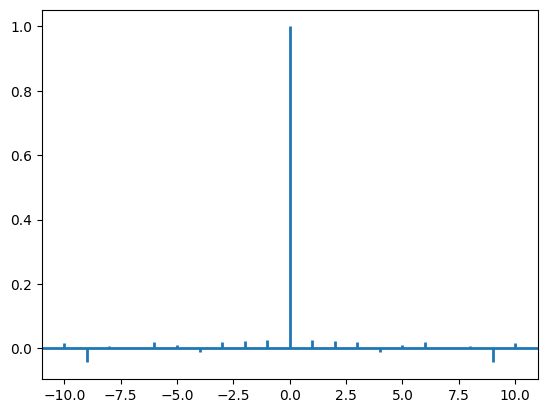

In [22]:
plt.acorr(y_train[y_train.index.hour==5]['spot_id_delta'], usevlines=True, 
    normed=True, 
    maxlags=10, 
    lw=2
  )

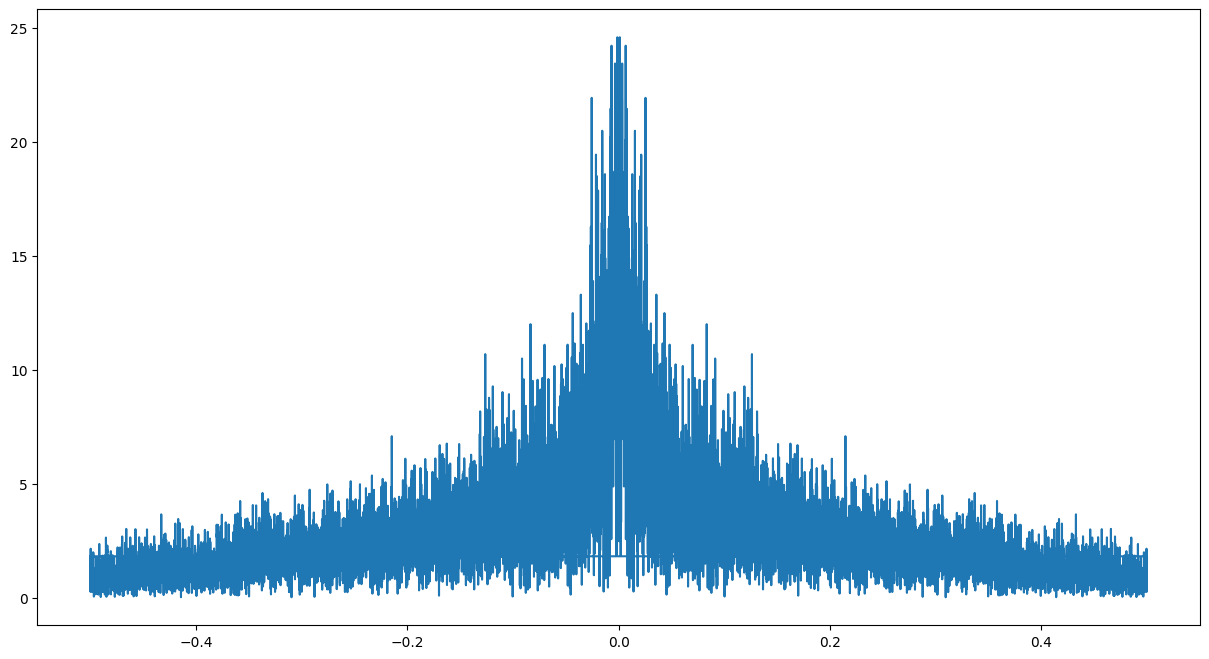

In [23]:
from numpy.fft import fft
from numpy.fft import fftfreq

ft = fft(y_train['spot_id_delta'])
ft_norm = list(map(lambda x: np.sqrt(x.real**2 + x.imag**2)/1000, ft))
freq = fftfreq(len(ft_norm))

plt.figure(figsize=(15,8))
plt.plot(freq[1:], ft_norm[1:])

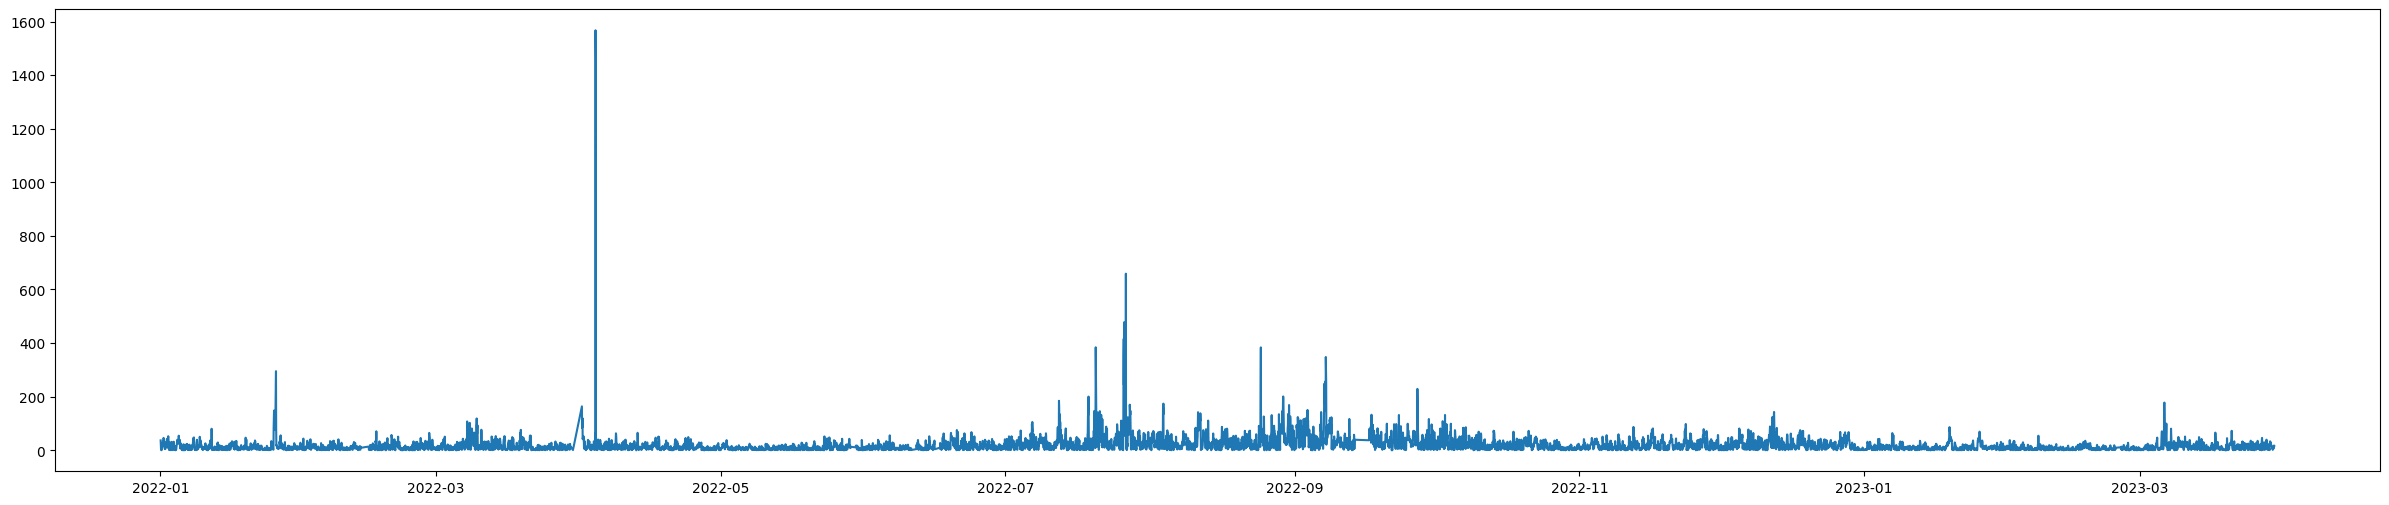

In [24]:
plt.figure(figsize=(30,6))
plt.plot(np.abs(y_train))

In [25]:
dates = y_train.sort_values(by='spot_id_delta', key=lambda x:np.abs(x),ascending=False)[:15].index
dates

DatetimeIndex(['2022-04-04 05:00:00+00:00', '2022-04-04 06:00:00+00:00',
               '2022-07-26 20:00:00+00:00', '2022-07-26 11:00:00+00:00',
               '2022-07-26 09:00:00+00:00', '2022-07-20 09:00:00+00:00',
               '2022-08-24 18:00:00+00:00', '2022-07-26 08:00:00+00:00',
               '2022-09-07 16:00:00+00:00', '2022-07-20 10:00:00+00:00',
               '2022-09-07 17:00:00+00:00', '2022-01-25 18:00:00+00:00',
               '2022-08-24 17:00:00+00:00', '2022-09-07 14:00:00+00:00',
               '2022-09-07 13:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='DELIVERY_START', freq=None)

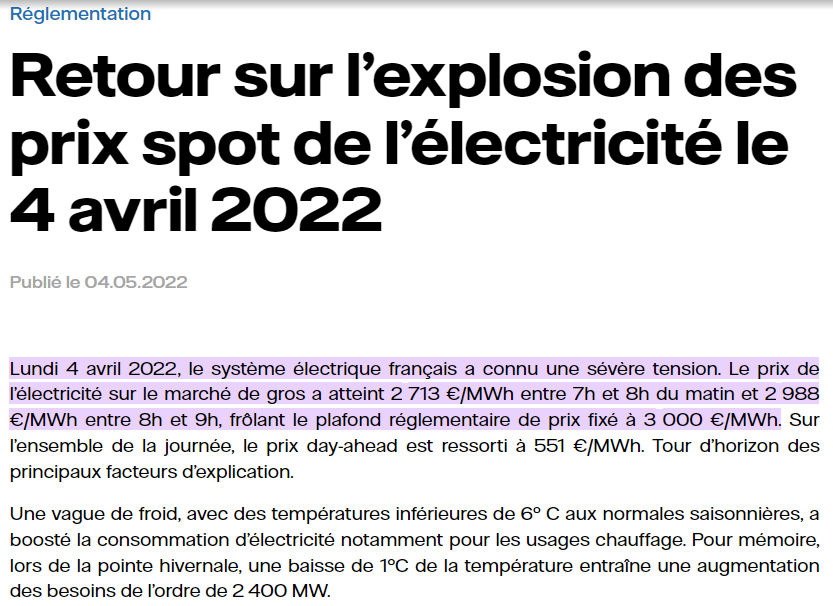

https://www.cre.fr/content/download/25791/file/Rapport_pic_prix_4avril2022.pdf 

In [26]:
x_train.columns

Index(['load_forecast', 'coal_power_available', 'gas_power_available',
       'nucelear_power_available', 'wind_power_forecasts_average',
       'solar_power_forecasts_average', 'wind_power_forecasts_std',
       'solar_power_forecasts_std', 'predicted_spot_price'],
      dtype='object')

In [27]:
x_train['conso_prod_delta'] = x_train['load_forecast']-(x_train['coal_power_available'] + x_train['gas_power_available']+ x_train['nucelear_power_available'] + x_train['solar_power_forecasts_average']+ x_train['wind_power_forecasts_average'])

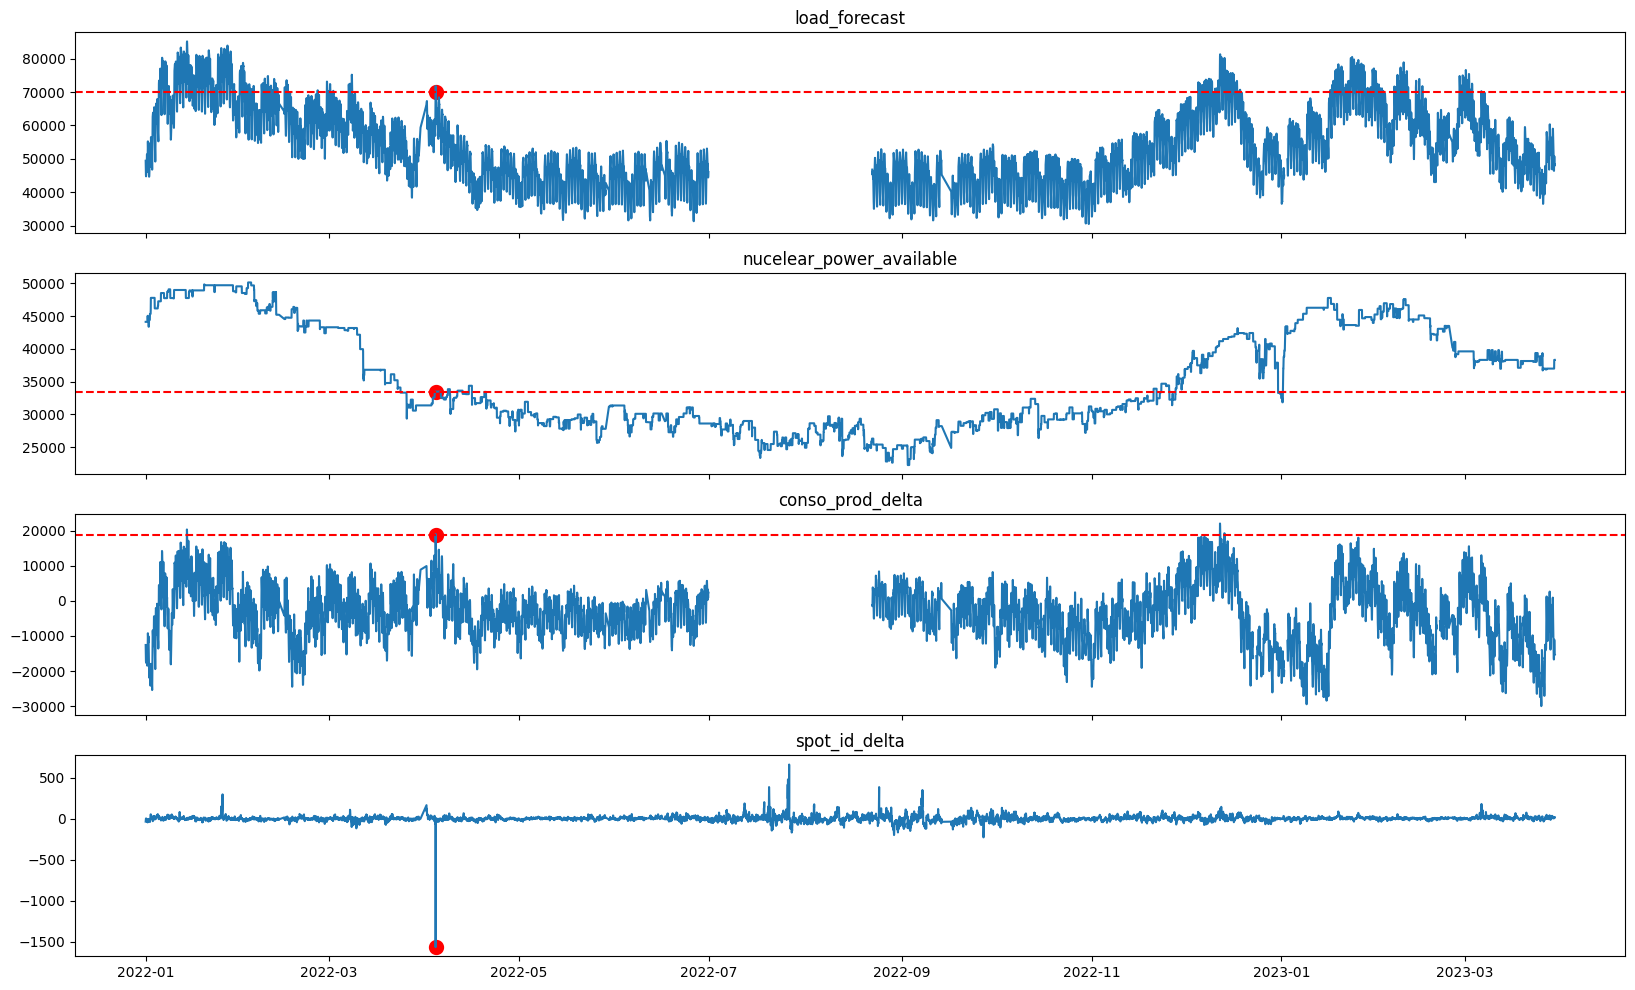

In [28]:
columns = ['load_forecast', 'nucelear_power_available','conso_prod_delta']
f, ax = plt.subplots(len(columns)+1, 1, sharex=True, figsize=(20,12))
for i, col in enumerate(columns):    
    ax[i].plot(x_train[col])
    for date in [dates[0]]:
        ax[i].scatter(date, x_train.loc[date, col], color='red', marker='o',linewidth=5)
        ax[i].axhline(x_train.loc[date, col],color='red', linestyle='--')
    ax[i].set_title(str(col))
ax[-1].plot(y_train['spot_id_delta'])
for date in [dates[0]]:
    ax[-1].scatter(date, y_train.loc[date, 'spot_id_delta'], color='red', marker='o', linewidth=5)
    ax[-1].set_title('spot_id_delta')

In [29]:
x_train.sort_values(by='load_forecast', ascending=False)['load_forecast']

DELIVERY_START
2022-01-14 08:00:00+00:00    85145.0
2022-01-14 07:00:00+00:00    84772.0
2022-01-14 09:00:00+00:00    84442.0
2022-01-27 08:00:00+00:00    83895.0
2022-01-27 09:00:00+00:00    83585.0
                              ...   
2023-01-02 18:00:00+00:00        NaN
2023-01-02 19:00:00+00:00        NaN
2023-01-02 20:00:00+00:00        NaN
2023-01-02 21:00:00+00:00        NaN
2023-01-02 22:00:00+00:00        NaN
Name: load_forecast, Length: 10605, dtype: float64

<Axes: ylabel='Frequency'>

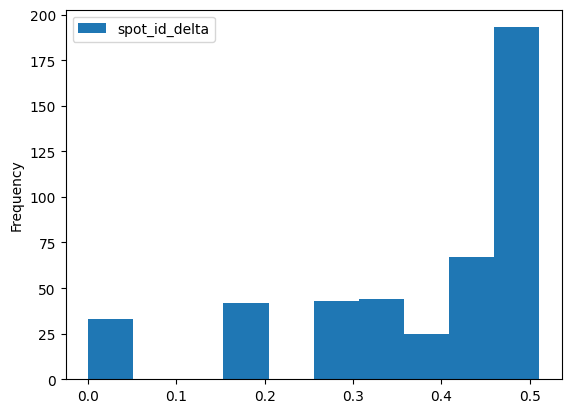

In [30]:
def process_target(y_train, binarize=False):
    if binarize:
        y_train = (y_train >= 0).astype(int)
    return y_train

y_train_bin = process_target(y_train, binarize=True)
y_train_bin.groupby(y_train_bin.index.date).std().plot(kind='hist')

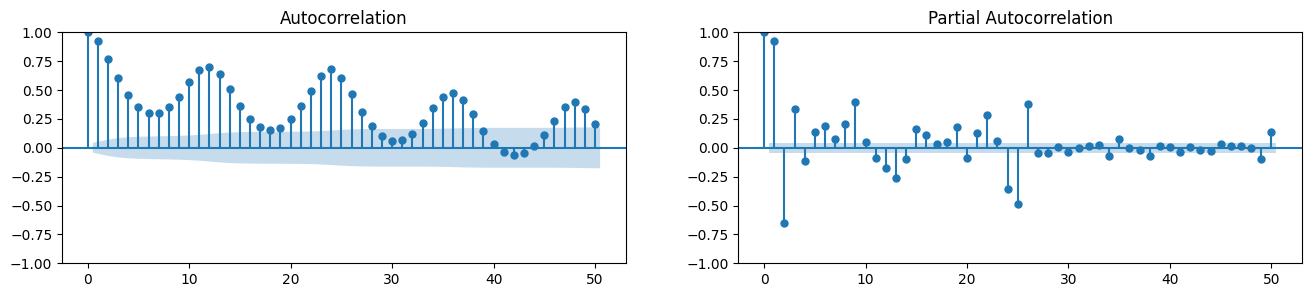

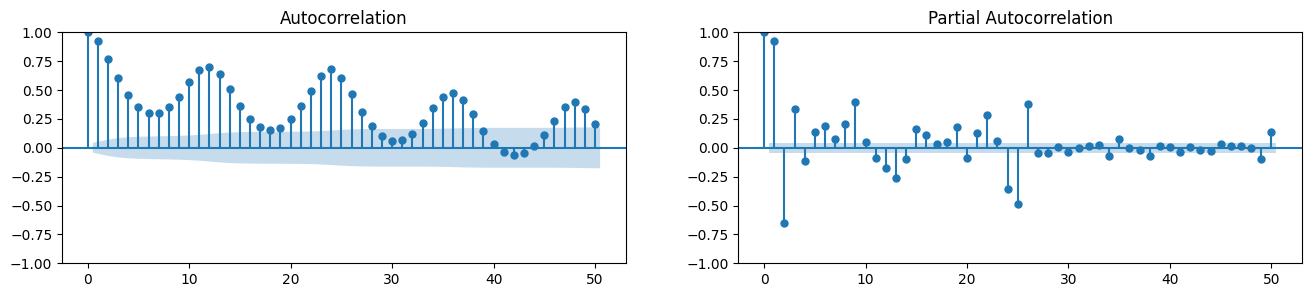

In [31]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_50 = acf(x_train['conso_prod_delta']['2022-03':'2022-05'], nlags=50)
pacf_50 = pacf(x_train['conso_prod_delta']['2022-03':'2022-05'], nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(x_train['conso_prod_delta']['2022-03':'2022-05'].tolist(), lags=50, ax=axes[0])
plot_pacf(x_train['conso_prod_delta']['2022-03':'2022-05'].tolist(), lags=50, ax=axes[1])

### Ruptures detection

## 5. Feature time plots 

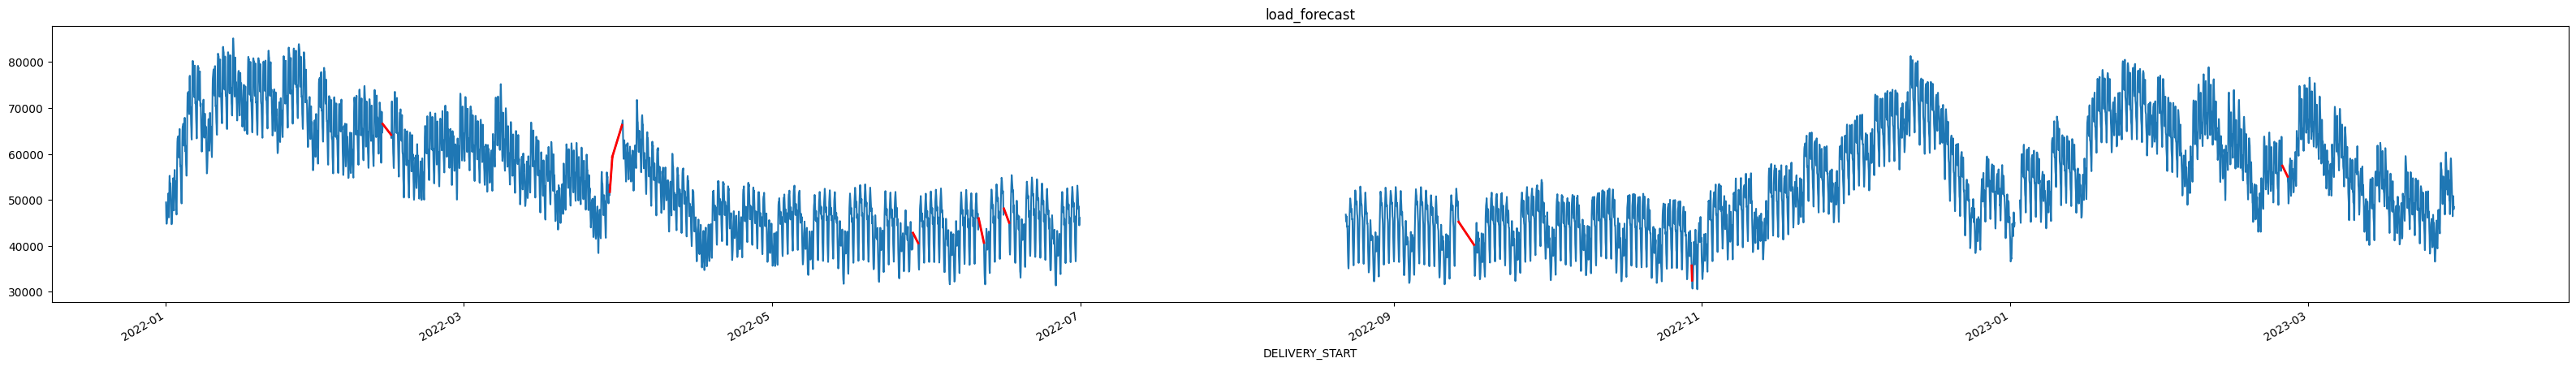

In [32]:
columns = ['load_forecast']
for col in columns:
    plt.figure(figsize=(40,5))
    x_train[col].plot()
    for _,line in diff_spacings_train.iterrows():
        x_train[col][line['n-1']:line['n']].plot(color='red',linewidth='2')
    plt.title(col)
    plt.show()

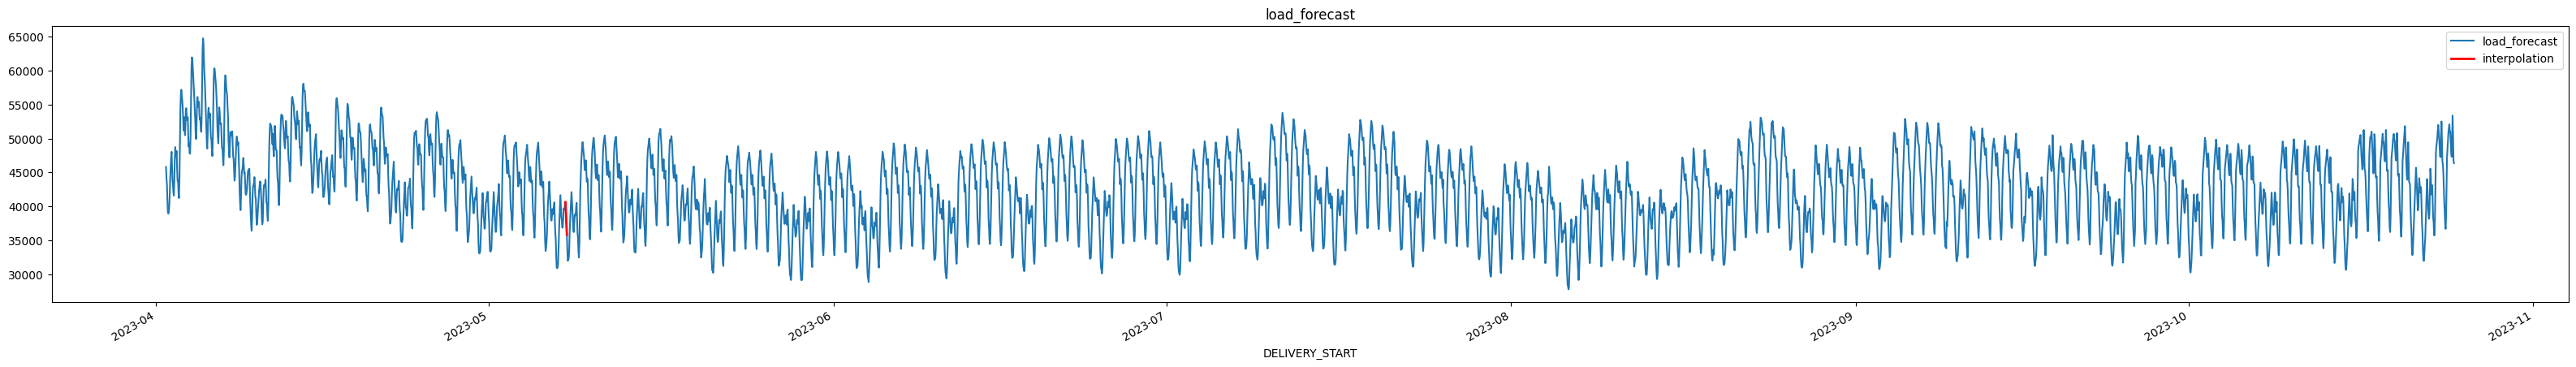

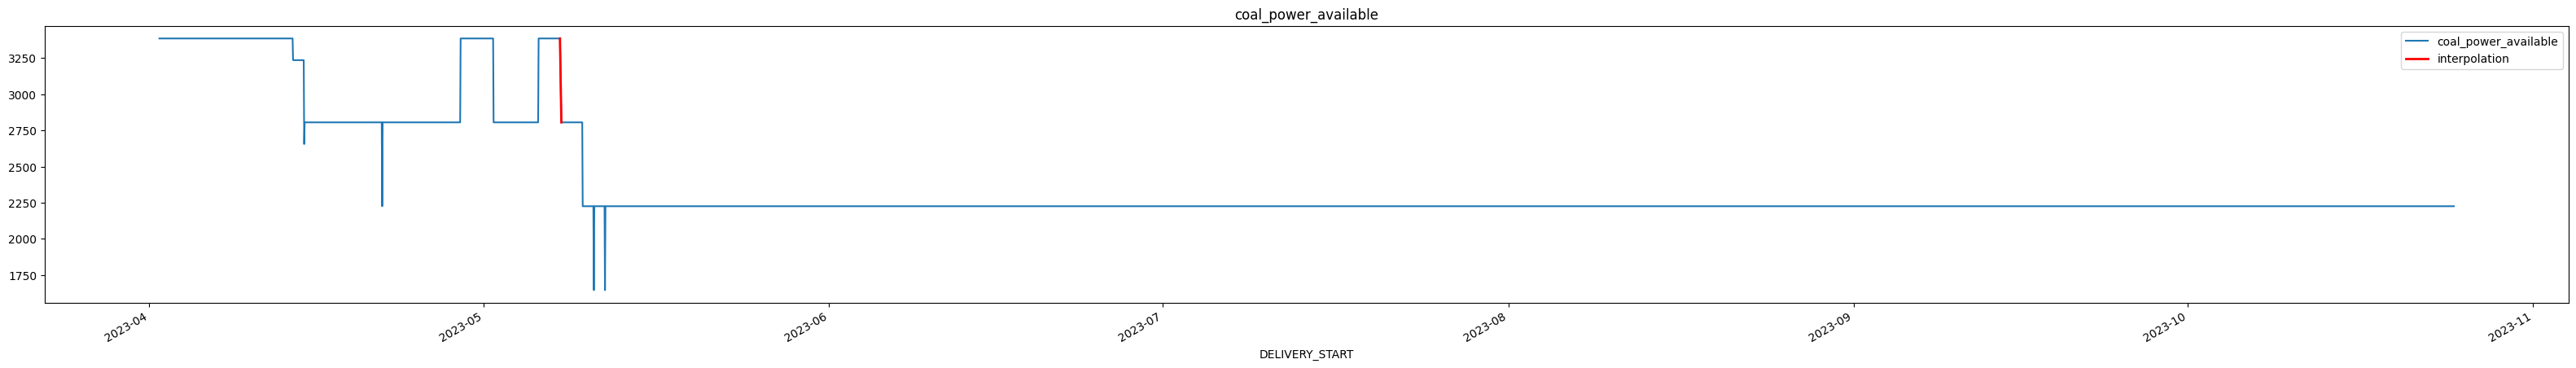

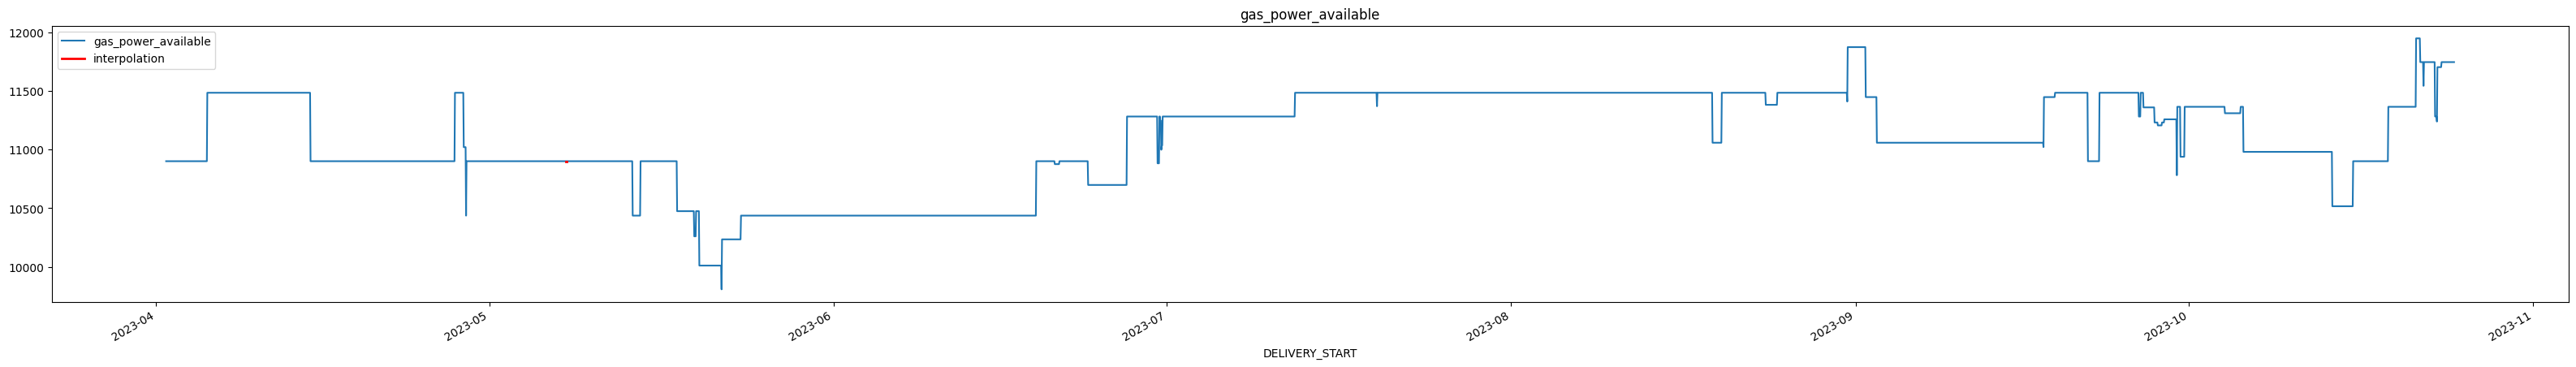

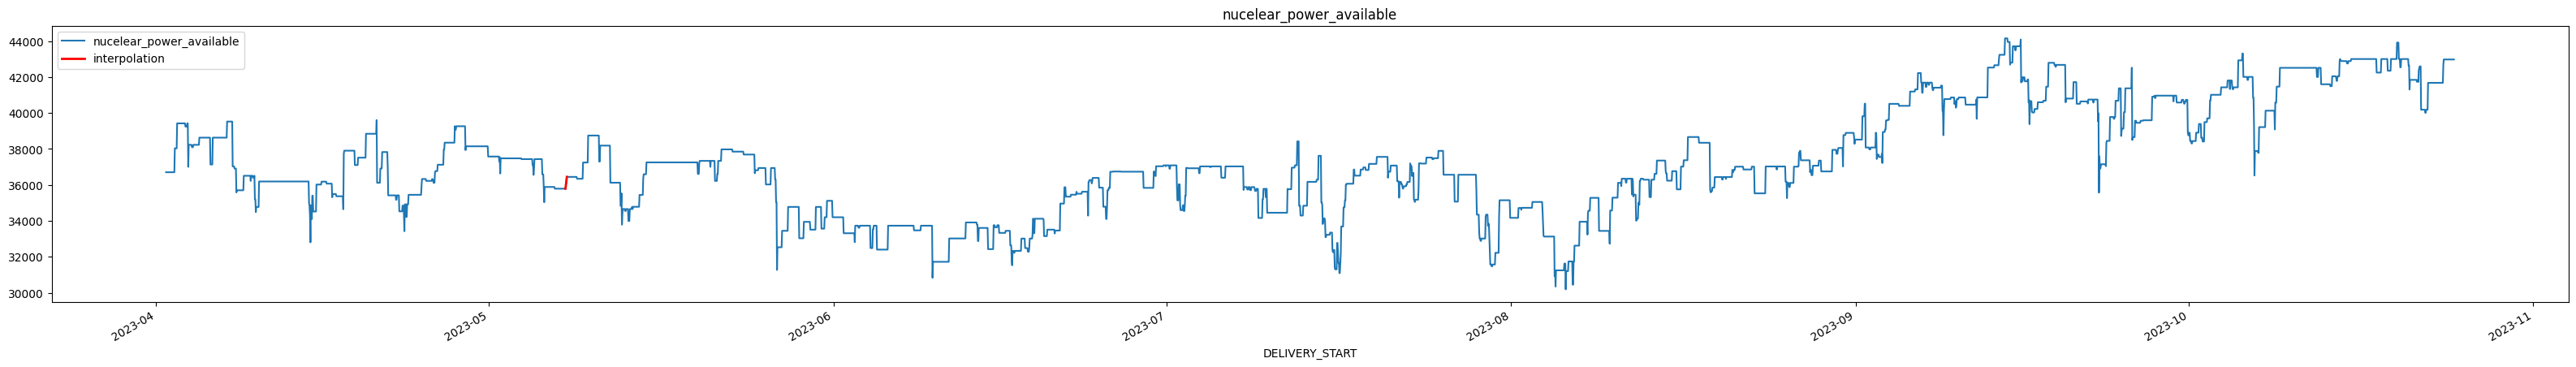

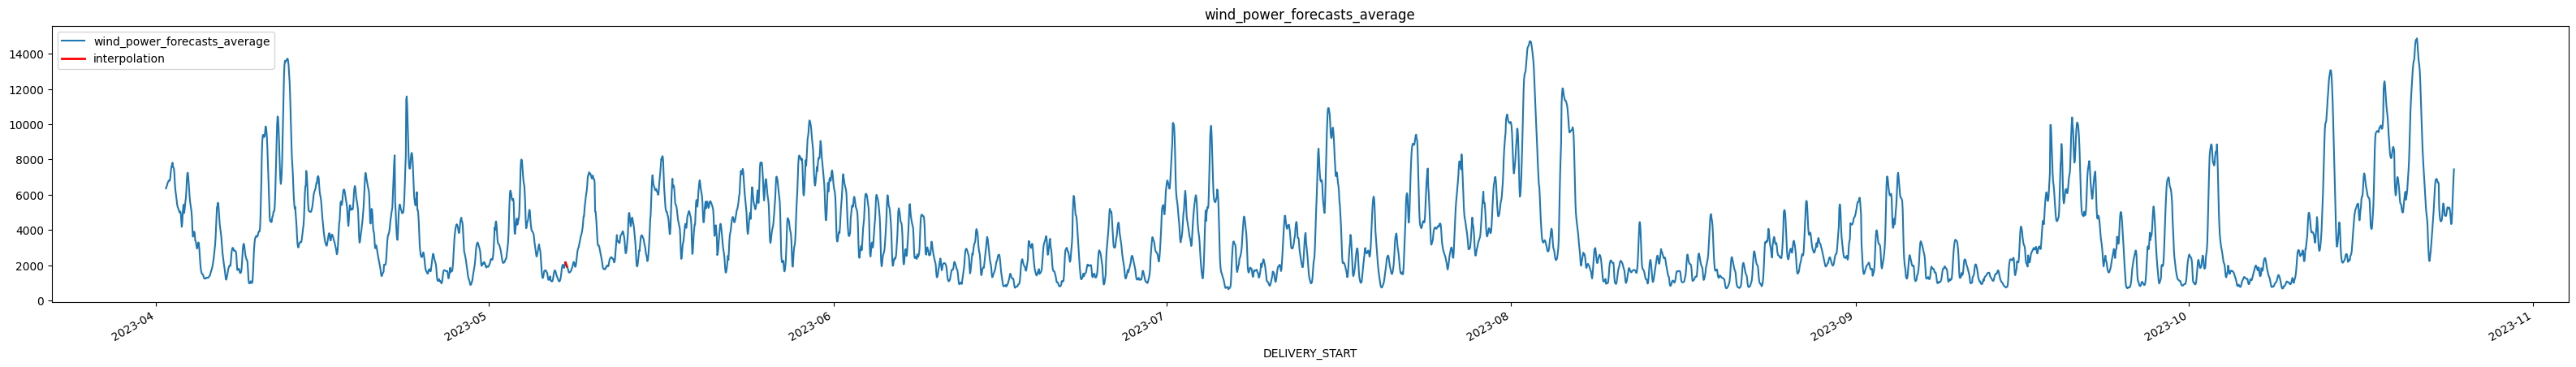

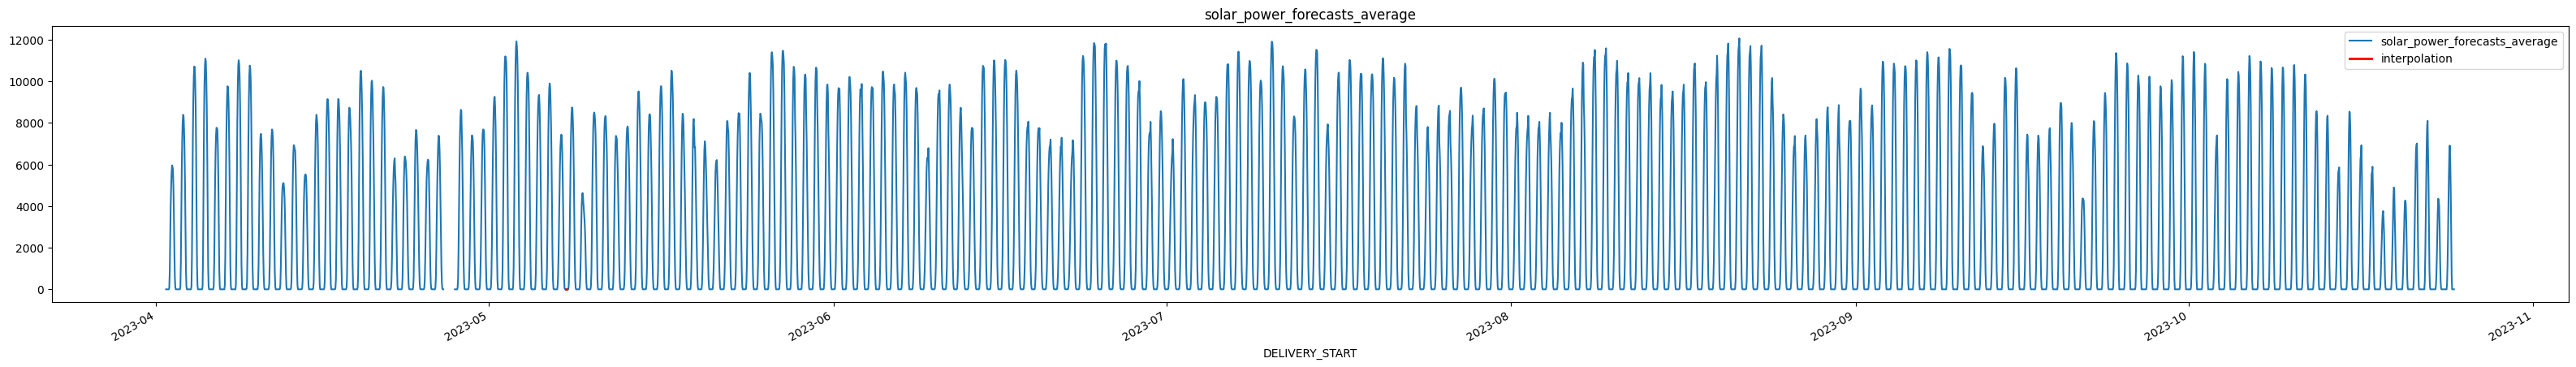

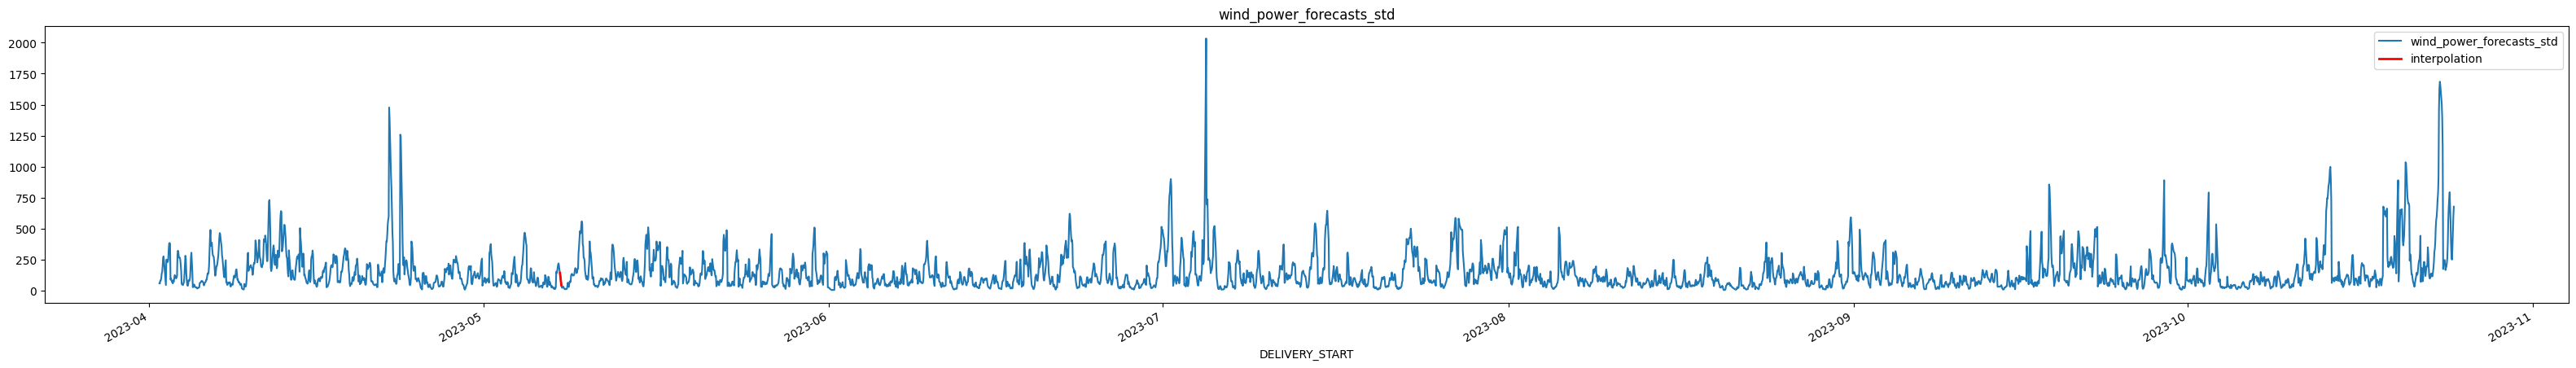

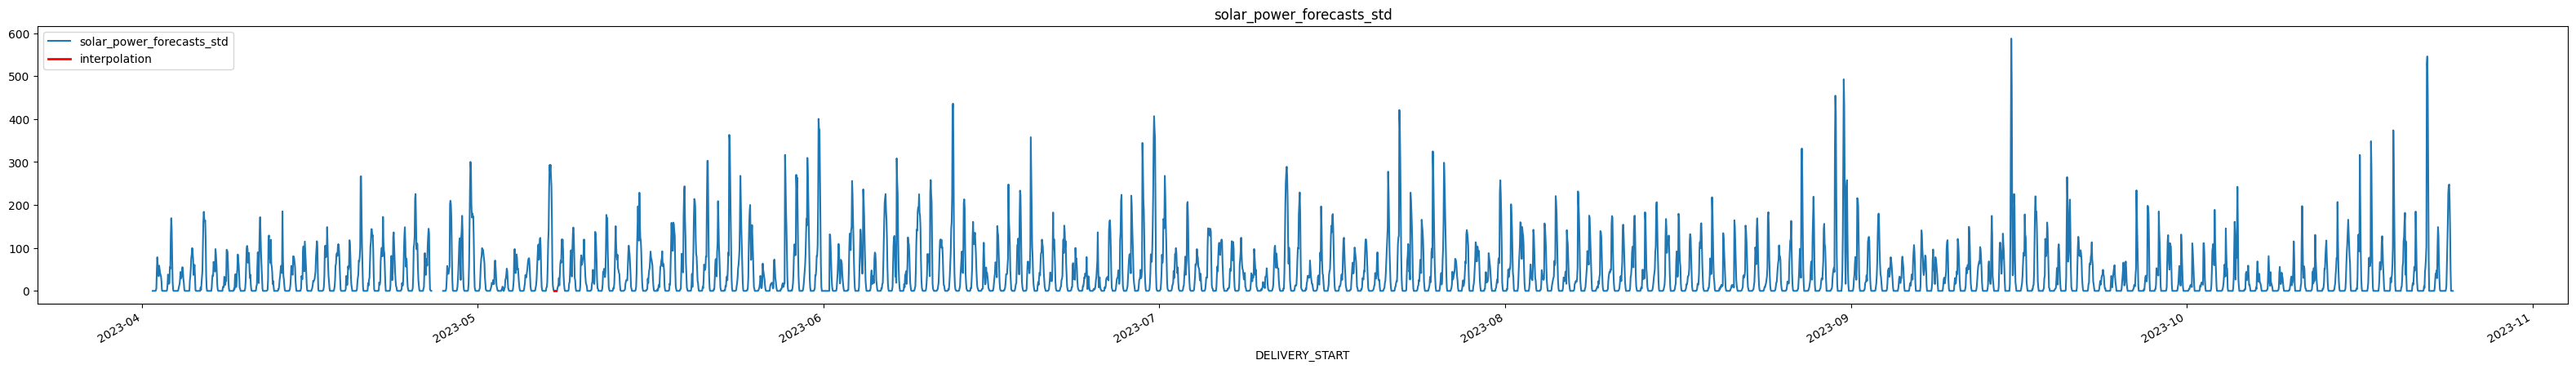

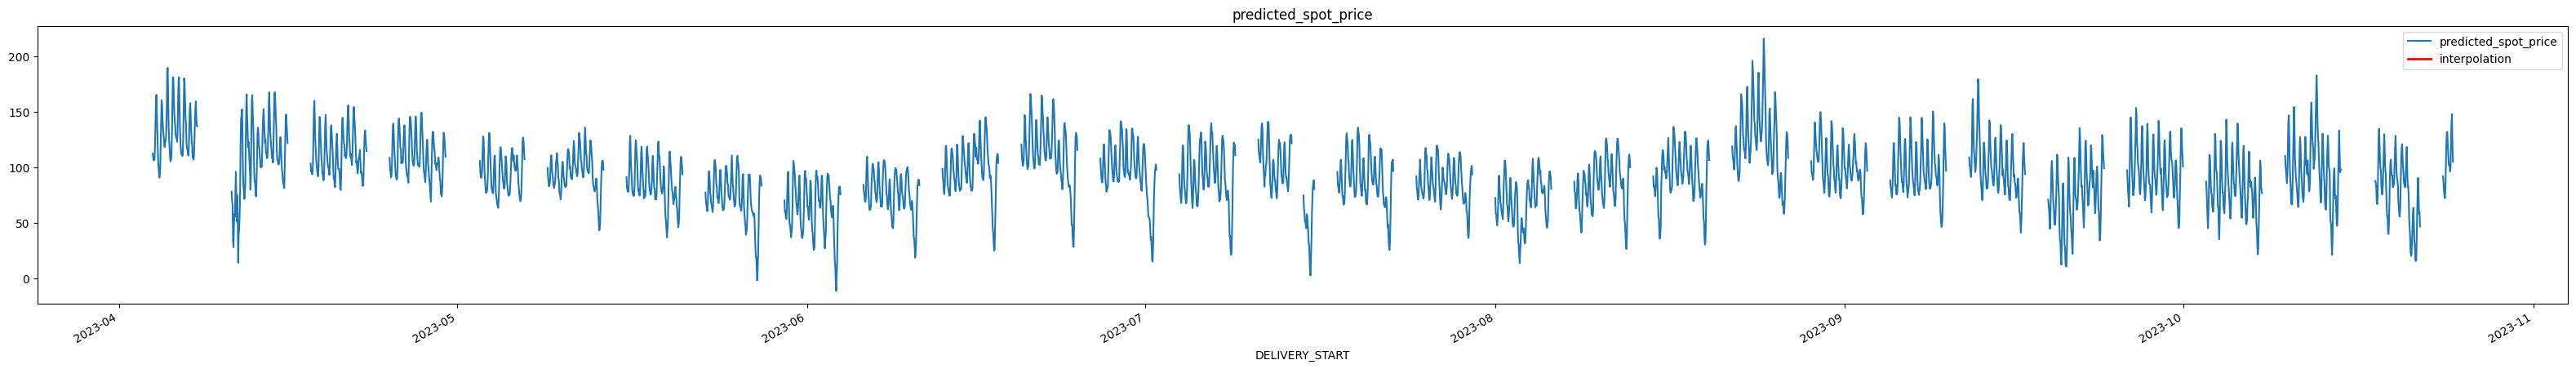

In [33]:
for col in x_test.columns:
    plt.figure(figsize=(40,5))
    x_test[col].plot()
    for _,line in diff_spacings_test.iterrows():
        x_test[col][line['n-1']:line['n']].plot(color='red',linewidth='2', label = 'interpolation')
    plt.legend()
    plt.title(col)
    plt.show()

## 6. Outliers

It does not matter if target is binarized

https://getnave.com/blog/should-you-remove-outliers-from-your-data-set/#:~:text=Removing%20outliers%20will%20help%20you,the%20accuracy%20of%20your%20forecast. 

https://pro.arcgis.com/en/pro-app/latest/tool-reference/space-time-pattern-mining/understanding-outliers-in-time-series-analysis.htm#:~:text=Locations%20with%20outliers%2C%20particularly%20outliers,forecasted%20values%20at%20each%20location.

## Imputing missing values

<Axes: ylabel='DELIVERY_START'>

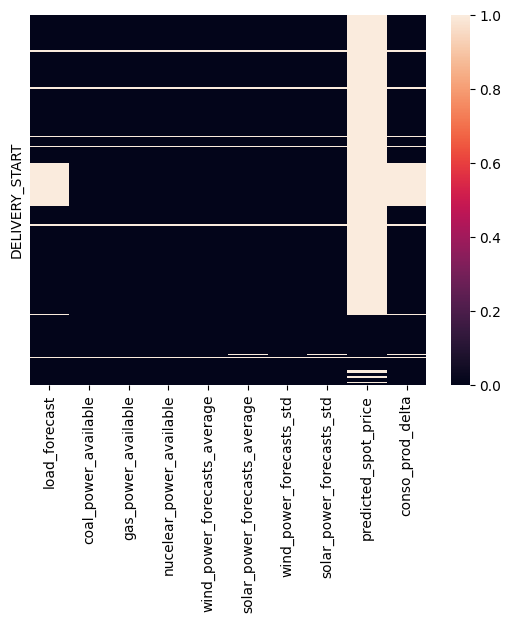

In [34]:
x_train_copy = x_train.copy()
x_train_copy = x_train_copy.resample('1h').mean()
sns.heatmap(x_train_copy.isna(),yticklabels=False)

In [35]:
original_x_train_indices = np.where(x_train_copy['original'] == 1)
original_x_train_indices

KeyError: 'original'

In [ ]:
# Null indices, and null patches (intervals) from null indices
null_indices = x_train_copy[x_train_copy['load_forecast'].isnull()].index
null_patches = []
patch = []
for i in range(len(null_indices)-1):
    patch.append(null_indices[i])
    if null_indices[i+1] != null_indices[i]+pd.Timedelta('1h'):
        null_patches.append(patch)
        patch = []
len(null_patches)

10

In [ ]:
patches_len = list(map(lambda p : len(p), null_patches))
longest_patch_ind = np.argmax(patches_len)

### TREND

<Axes: >

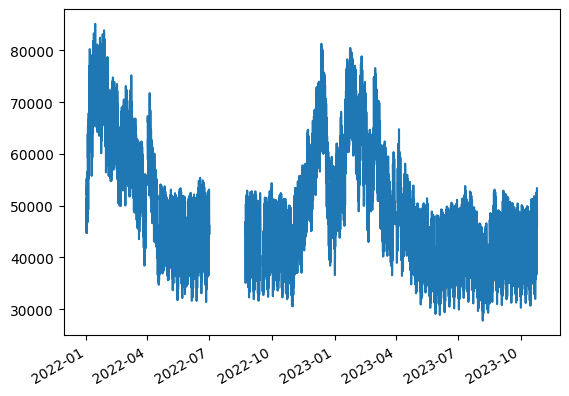

In [ ]:
all_index = pd.to_datetime(np.hstack((x_train_copy['load_forecast'].index, x_test['load_forecast'].index)))
all_load_forecast = np.hstack((x_train_copy['load_forecast'], x_test['load_forecast']))
all_data = pd.DataFrame(index = all_index, data=all_load_forecast, columns=['load_forecast'])
all_data['load_forecast'].plot()

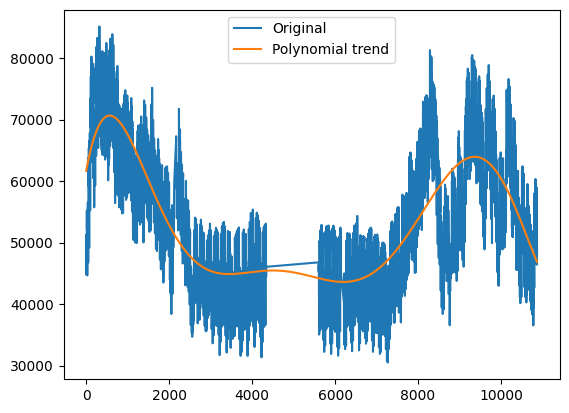

In [ ]:
DEGREE = 9
signal_train = x_train_copy['load_forecast'].interpolate()
time_array_train = np.arange(len(signal_train.index))
coeffs = np.polyfit(time_array_train, signal_train, DEGREE)
approx_poly_trend = np.polyval(coeffs, time_array_train)

plt.plot(time_array_train,signal_train, label="Original")
plt.plot(approx_poly_trend, label="Polynomial trend")
plt.legend()

In [ ]:
x_train_copy['trend'] = approx_poly_trend

### SEASONALITY

![explanation](images/harmonic_reg.jpg)

In [ ]:
#UTILITY FUNCTION
from scipy.signal import argrelmax, periodogram

def get_largest_local_max(
    signal1D: np.ndarray, n_largest: int = 3, order: int = 1) -> [np.ndarray, np.ndarray]:
    """Return the largest local max and the associated index in a tuple.

    This function uses `order` points on each side to use for the comparison.
    """
    all_local_max_indexes = argrelmax(signal1D, order=order)[0]
    all_local_max = np.take(signal1D, all_local_max_indexes)
    largest_local_max_indexes = all_local_max_indexes[all_local_max.argsort()[::-1]][
        :n_largest
    ]

    return (
        np.take(signal1D, largest_local_max_indexes),
        largest_local_max_indexes,
    )

<Axes: xlabel='DELIVERY_START'>

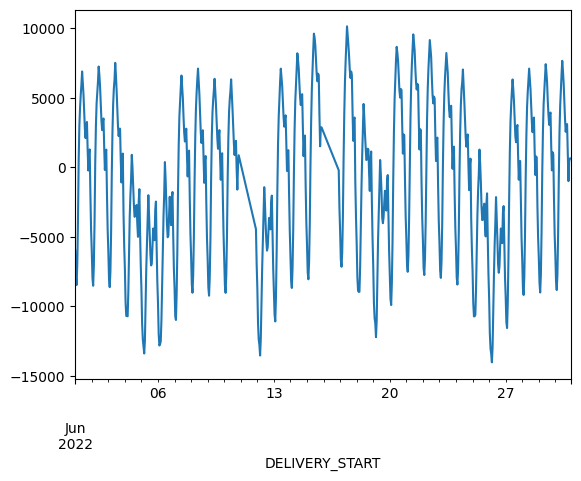

In [ ]:
signal = (x_train_copy['load_forecast']['06-2022'] - x_train_copy['trend']['06-2022']).interpolate()
time_array = np.arange(signal.size)
signal.plot()

In [ ]:
# signal = (x_train_copy['load_forecast']['01-2022'] - x_train_copy['trend']['01-2022']).interpolate()
# time_array = np.arange(signal.size)
# signal.plot()

array([0.04166667, 0.08333333, 0.00555556])

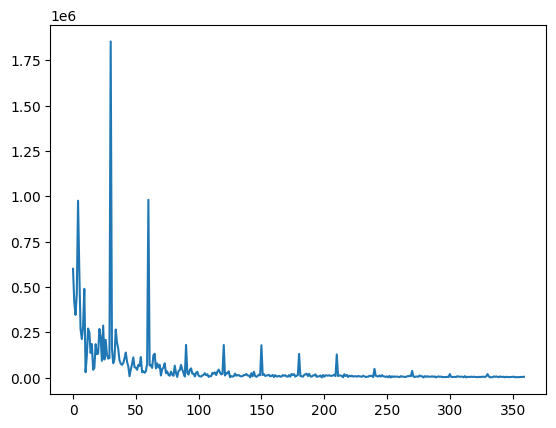

In [ ]:
NB_FREQS = 3
fft_values = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(signal), 3600)
positive_freqs = frequencies[:len(frequencies)//2]
magnitude_spectrum = np.abs(fft_values[:len(fft_values)//2])
plt.plot(magnitude_spectrum)
max_freq, max_freq_idx =get_largest_local_max(magnitude_spectrum, n_largest=NB_FREQS)
freqs = frequencies[max_freq_idx]*3600
(1/freqs)
freqs

In [ ]:
#UTILITY FUNCTION
def build_matrix_harmonic_reg(freqs, time_array):
    A_matrix = np.array([(np.cos(2 * np.pi * fi * time_array), np.sin(2 * np.pi * fi * time_array)) for fi in freqs])
    A_matrix = A_matrix.reshape(len(freqs)*2,-1)
    A_matrix = np.vstack((A_matrix, np.array([np.ones(time_array.size)])))
    A_matrix = A_matrix.T
    return A_matrix

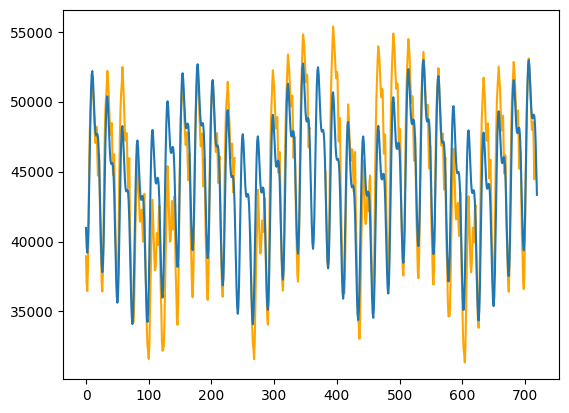

In [ ]:
A_matrix = build_matrix_harmonic_reg(freqs, time_array)
coefs = np.linalg.lstsq(A_matrix, signal, rcond=None)[0]
plt.plot(time_array, x_train_copy['load_forecast']['06-2022'], label="Original", color='orange')
plt.plot(time_array, A_matrix @ coefs+ x_train_copy['trend']['06-2022']  , label="Model")

In [ ]:
# Given date
given_date = pd.Timestamp('2022-06-01', tz='UTC')

df = x_train_copy.copy()
# Convert the datetime column into timedelta relative to the given date
df['TimeDelta'] = df.index - given_date

# Convert timedelta to hours (as integers)
df['Hours'] = df['TimeDelta'].dt.total_seconds() // 3600  # 3600 seconds in an hour

# Convert Hours column to a list of integers
hours_list = np.array(df['Hours'].astype(int).tolist())
hours_list

array([-3623, -3622, -3621, ...,  7243,  7244,  7245])

<Axes: xlabel='DELIVERY_START'>

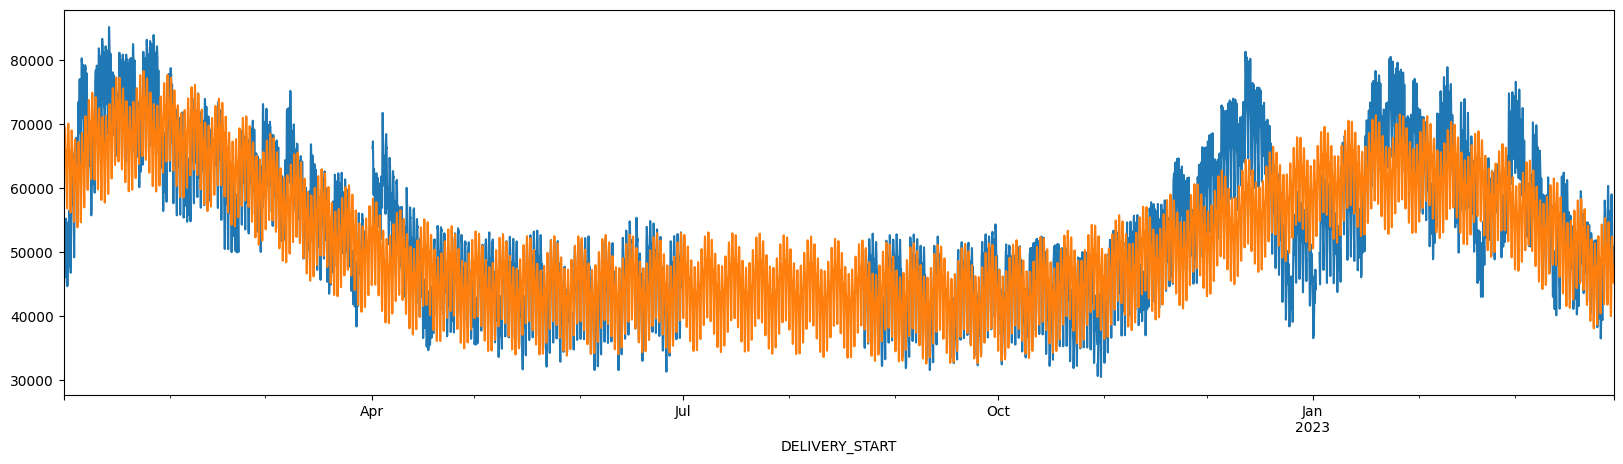

In [ ]:
A_matrix = build_matrix_harmonic_reg(freqs, hours_list)
plt.figure(figsize=(20,5))
x_train_copy['load_forecast'].plot()
x_train_copy['load_forecast_new'] = x_train_copy['trend'] +  (A_matrix @ coefs)
x_train_copy['load_forecast_new'].plot()

<Axes: xlabel='DELIVERY_START'>

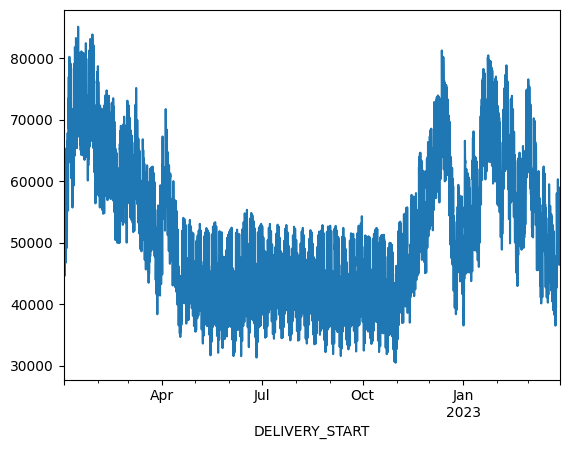

In [ ]:
x_train_copy.loc[null_indices, 'load_forecast']= x_train_copy['load_forecast_new']
x_train_copy['load_forecast'].plot()

### Functions to perform end-to-end missing values replacement

In [ ]:
#UTILITY FUNCTION
def build_matrix_harmonic_reg(freqs, time_array):
    A_matrix = np.array([(np.cos(2 * np.pi * fi * time_array), np.sin(2 * np.pi * fi * time_array)) for fi in freqs])
    A_matrix = A_matrix.reshape(len(freqs)*2,-1)
    A_matrix = np.vstack((A_matrix, np.array([np.ones(time_array.size)])))
    A_matrix = A_matrix.T
    return A_matrix

In [ ]:
#UTILITY FUNCTION
from scipy.signal import argrelmax, periodogram

def get_largest_local_max(
    signal1D: np.ndarray, n_largest: int = 3, order: int = 1) -> [np.ndarray, np.ndarray]:
    """Return the largest local max and the associated index in a tuple.

    This function uses `order` points on each side to use for the comparison.
    """
    all_local_max_indexes = argrelmax(signal1D, order=order)[0]
    all_local_max = np.take(signal1D, all_local_max_indexes)
    largest_local_max_indexes = all_local_max_indexes[all_local_max.argsort()[::-1]][
        :n_largest
    ]

    return (
        np.take(signal1D, largest_local_max_indexes),
        largest_local_max_indexes,
    )

In [ ]:
# function to partition a time series into intervals of NaNs and intervals of non-NaNs
def partition_na(column):
    '''
    Input :
        column (pd.Series with a datetime-like index)
    Returns : 
        null_patches (list) : list of intervals (list of consecutive points)
        
    '''
    null_indices = column[column.isnull()].index
    null_patches = []
    patch = [null_indices[0]]
    assert len(null_indices)>0
    for i in range(1,len(null_indices)):
        if null_indices[i] != null_indices[i-1]+pd.Timedelta('1h'):
            null_patches.append(patch)
            patch = [null_indices[i]]
        else:
            patch.append(null_indices[i])
    null_patches.append(patch)
    non_null_patches = []
    for i in range(len(null_patches)+1):
        # non_null interval situated directly on the left of the current null interval
        if i==0:
            if null_patches[i][0]==column.index[0]: #column starts with a NaN
                nan_first = True
                continue
            else:
                nan_first = False
                l1 = column.index[0]
                l2 = null_patches[i][-1] - pd.Timedelta('1h')           
        elif i==len(null_patches):
            if null_patches[i-1][-1]==column.index[-1]: #column ends with a NaN
                nan_last = True
                continue
            else:
                nan_last = False
                l1 = null_patches[i-1][-1] + pd.Timedelta('1h')
                l2 = column.index[-1]
        else:
            l1 = null_patches[i-1][-1] + pd.Timedelta('1h')
            l2 = null_patches[i][0] - pd.Timedelta('1h')
        if len(list((column[l1:l2])))>10:
            non_null_patches.append(list((column[l1:l2]).index))
        
    return null_indices, null_patches, non_null_patches, nan_first, nan_last

In [ ]:
def relu(x):
    if x<0 :
        return 0
    else:
        return x

In [ ]:
def get_hours_from_date(time_index, date):
    # Convert the datetime column into timedelta relative to the given date
    time_delta = time_index - date
    # Convert timedelta to hours (as integers)
    hours = time_delta.total_seconds() // 3600  # 3600 seconds in an hour
    # Convert Hours column to a list of integers
    hours_list = np.array(hours.astype(int).tolist())
    return hours_list

In [ ]:
# function to perform missing values imputation
def impute_na(df, plot=False, trend_degree=9, seasonality_nb_freqs=4):
    '''
    Returns :
        df_imputed (DataFrame) : df resampled at '1h' intervals, without NaNs
        original_df_indices (ndarray) : indices of rows in `df_imputed` mapping to original df rows
    '''
    df_temp = df.copy()
    df_temp['original'] = 1
    df_temp = df_temp.resample('1h').mean()
    original_df_indices = np.where(df_temp['original'] == 1)

    na_columns = df_temp.columns[df_temp.isna().sum()>0]
    cols_to_drop = ['original']
    for column in na_columns:
        print('COLUMN : ', column)
        try:
            # Get trend of column signal
            signal = df_temp[column].interpolate()
            time_array = np.arange(len(signal.index))
            coeffs = np.polyfit(time_array, signal, trend_degree)
            approx_poly_trend = np.polyval(coeffs, time_array)
            df_temp[f'trend_{column}'] = approx_poly_trend
            cols_to_drop.append(f'trend_{column}')

            null_indices, null_patches, non_null_patches, _, _ = partition_na(df_temp[column])
            for i in range(len(null_patches)):
                # Get local seasonality (from signal on the left or on the right )
                if (len(null_patches) > len(non_null_patches)) and i==len(null_patches)-1:
                    non_null_interval = non_null_patches[i-1]
                else:
                    non_null_interval = non_null_patches[i]

                signal = (df_temp[column][non_null_interval] - df_temp[f'trend_{column}'][non_null_interval]).interpolate()
                time_array = np.arange(signal.size)
                fft_values = np.fft.fft(signal) 
                frequencies = np.fft.fftfreq(len(signal), 3600)
                # positive_freqs = frequencies[:len(frequencies)//2]
                magnitude_spectrum = np.abs(fft_values[:len(fft_values)//2])
                max_freq, max_freq_idx =get_largest_local_max(magnitude_spectrum, n_largest=seasonality_nb_freqs)
                freqs = frequencies[max_freq_idx]*3600 #in H^{-1}
                A_matrix = build_matrix_harmonic_reg(freqs, time_array)
                reg_coeffs = np.linalg.lstsq(A_matrix, signal, rcond=None)[0]
                hours_list = get_hours_from_date(df_temp.loc[null_patches[i],:].index, signal.index[0])
                A_matrix_na = build_matrix_harmonic_reg(freqs, hours_list)
                df_temp.loc[null_patches[i], column] = df_temp.loc[null_patches[i], f'trend_{column}'] + A_matrix_na @ reg_coeffs
                df_temp.loc[null_patches[i], column] = df_temp.loc[null_patches[i], column].apply(relu)
            if plot:
                plt.figure(figsize=(30,5))
                plt.plot(df_temp[column])
                for patch in null_patches:
                    plt.plot(df_temp.loc[patch,column], color='red')
                plt.title(f'{column}')
        except:
            print(f"Could not decompose {column} into trend/seasonality, doing simple interpolation")
            null_indices, null_patches, non_null_patches, _, _ = partition_na(df_temp[column])
            df_temp[column] = df_temp[column].fillna(method = 'ffill')

            if plot:
                plt.figure(figsize=(30,5))
                plt.plot(df_temp[column])
                for patch in null_patches:
                    plt.plot(df_temp.loc[patch,column], color='red')
                plt.title(f'{column}')
    df_temp.drop(cols_to_drop, axis=1, inplace=True)
    return df_temp, original_df_indices[0]

COLUMN :  load_forecast
COLUMN :  coal_power_available
Could not decompose coal_power_available into trend/seasonality, doing simple interpolation


C:\Users\TRETEC\AppData\Local\Temp\ipykernel_9676\4156669124.py:57: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp[column] = df_temp[column].fillna(method = 'ffill')


COLUMN :  gas_power_available
COLUMN :  nucelear_power_available
COLUMN :  wind_power_forecasts_average
Could not decompose wind_power_forecasts_average into trend/seasonality, doing simple interpolation


IndexError: index 0 is out of bounds for axis 0 with size 0

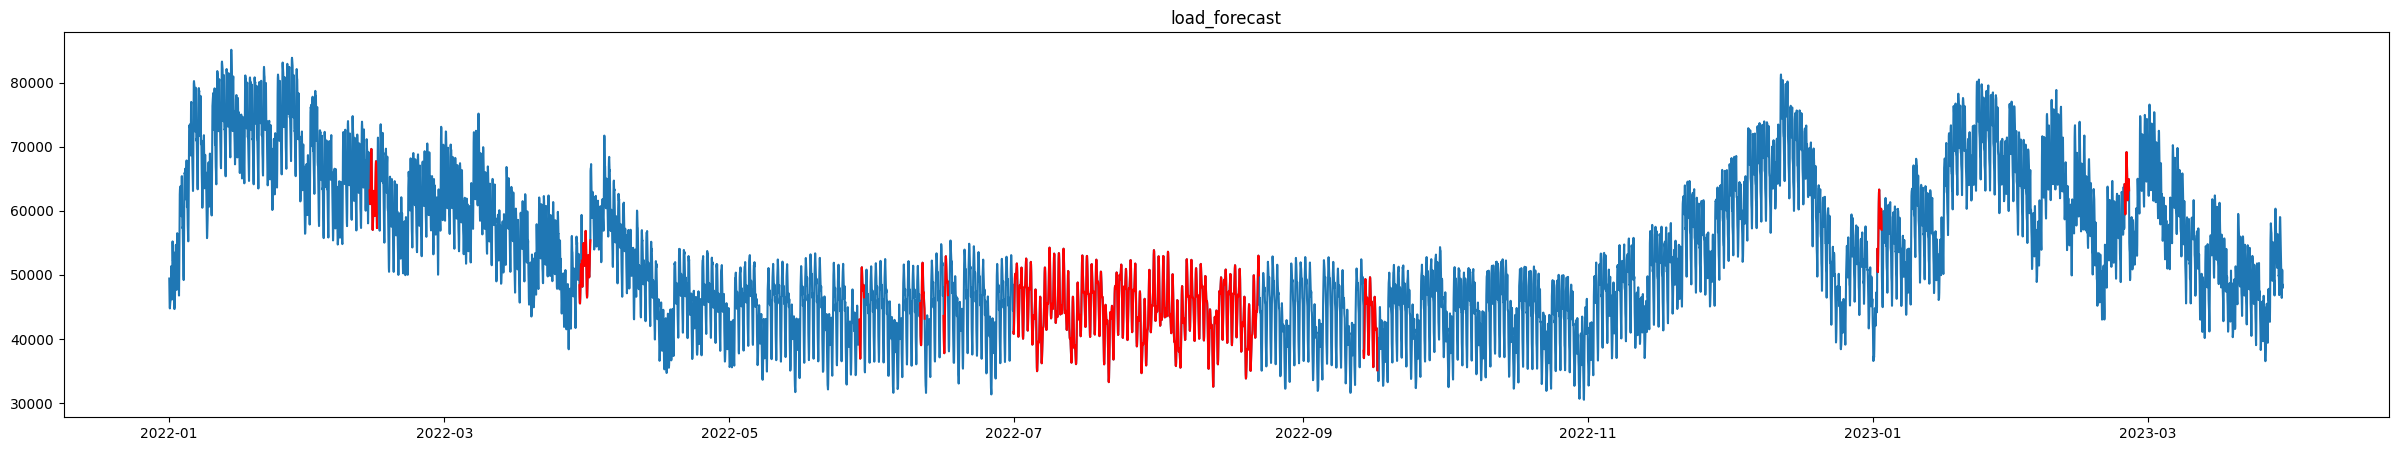

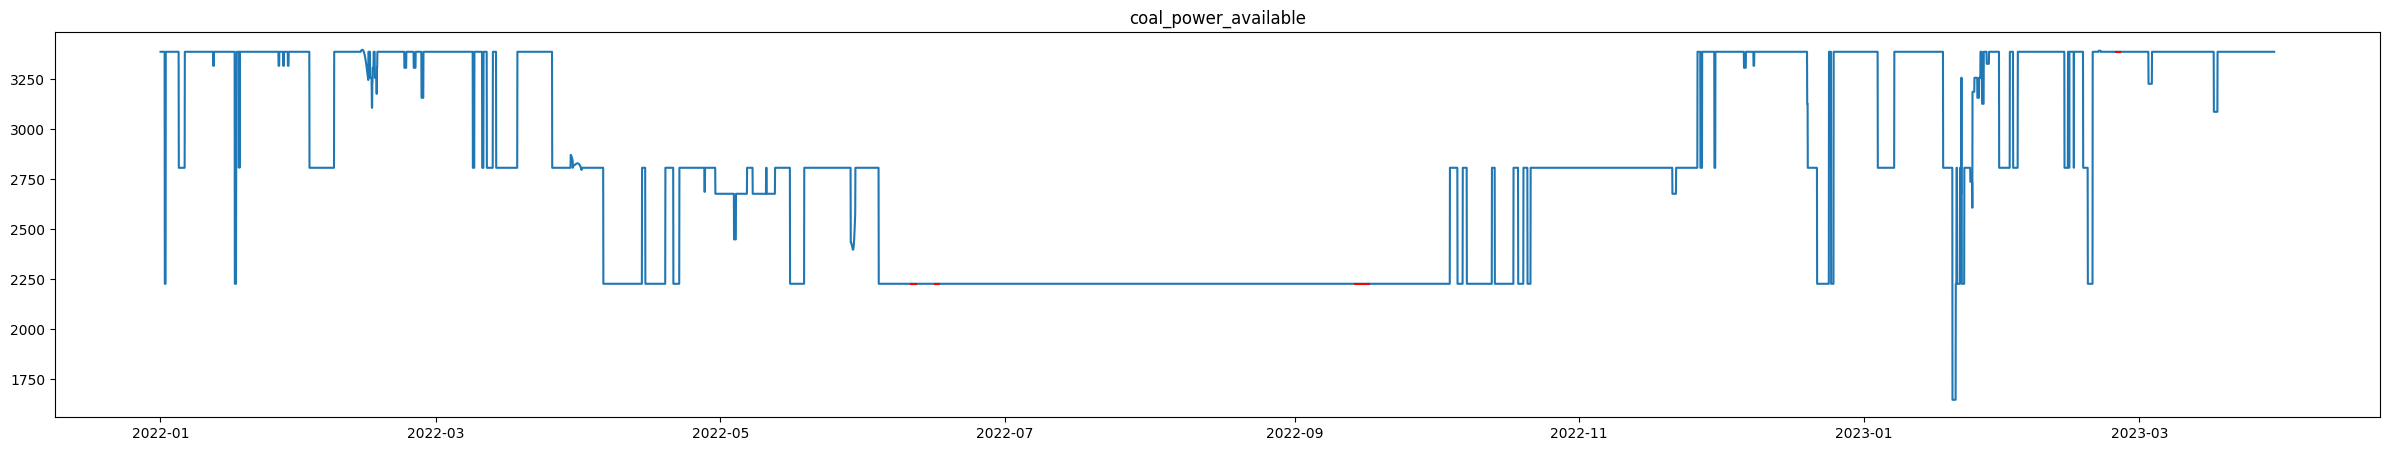

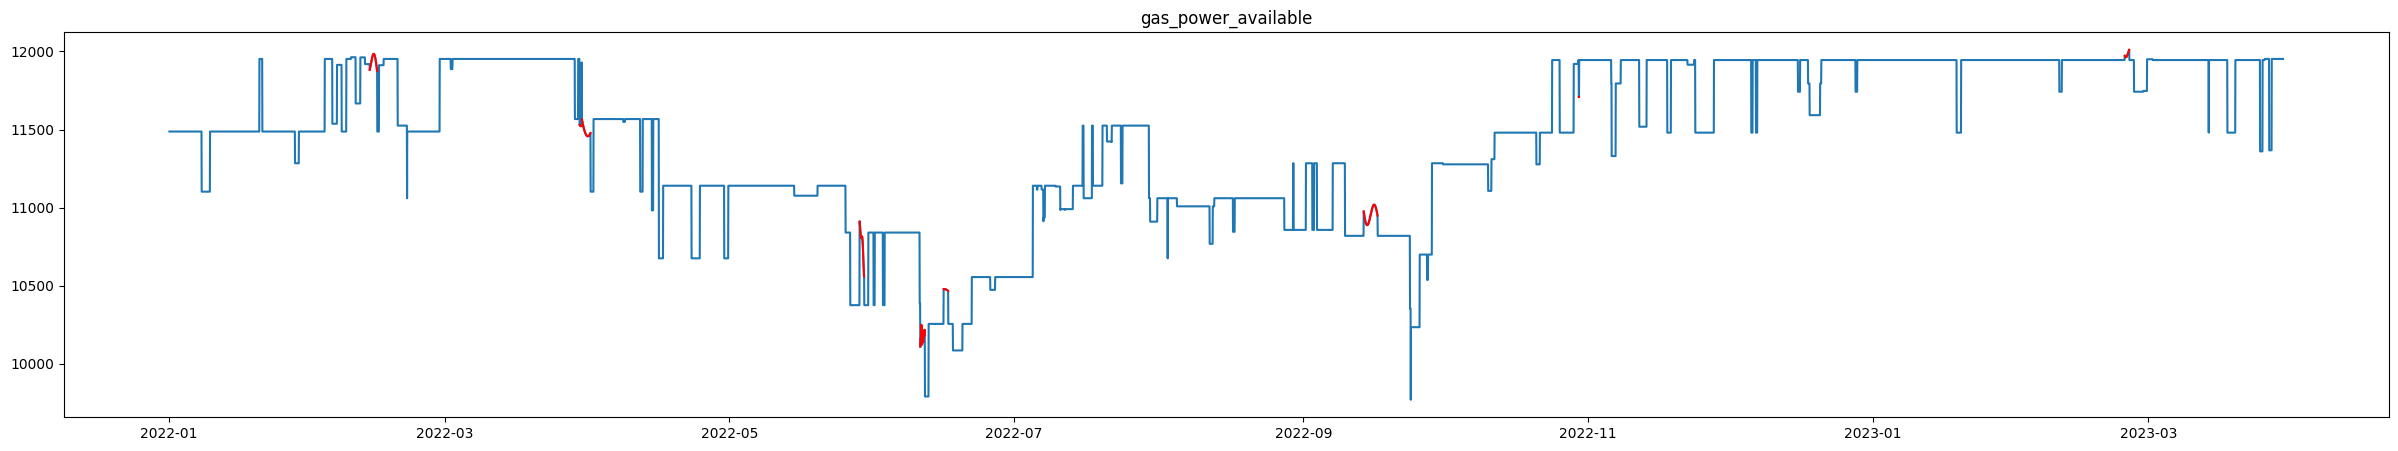

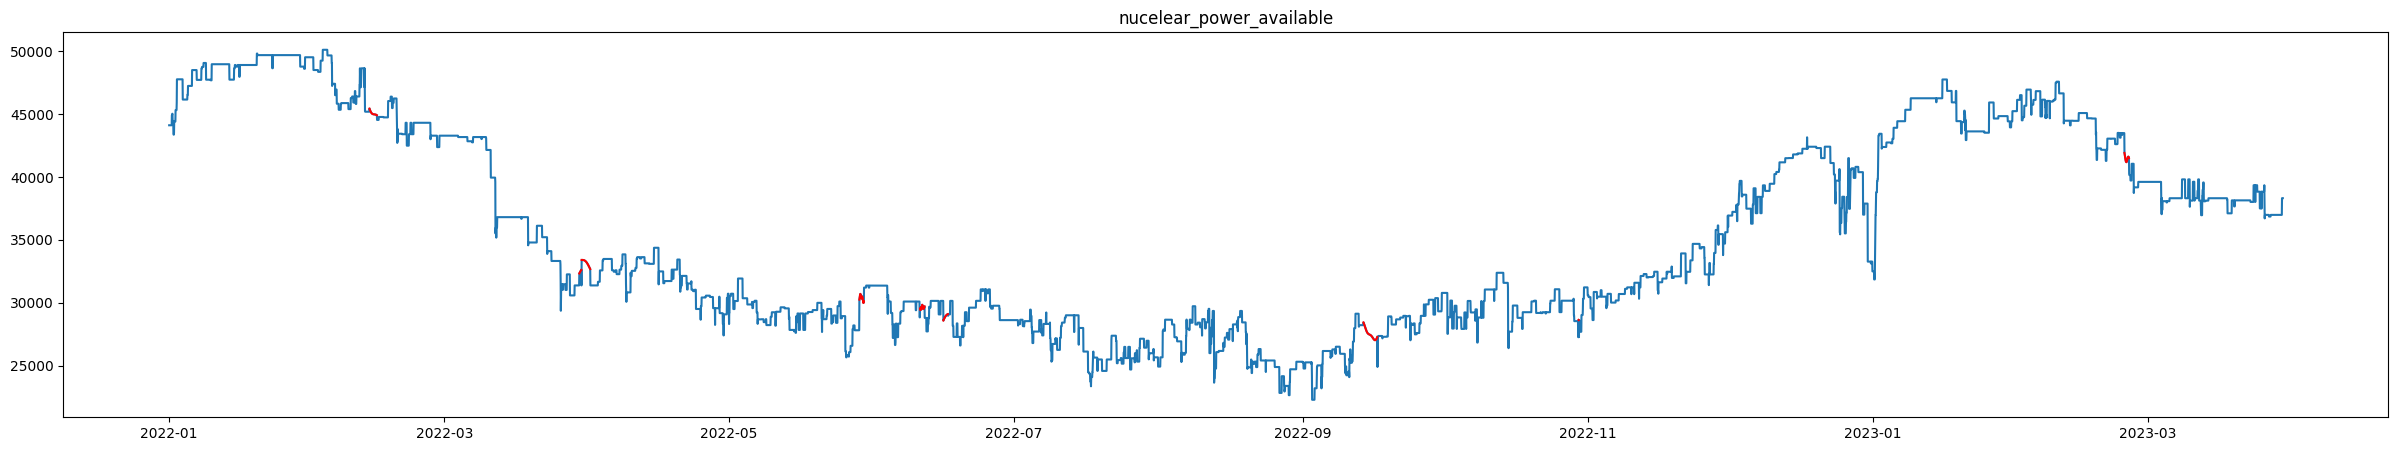

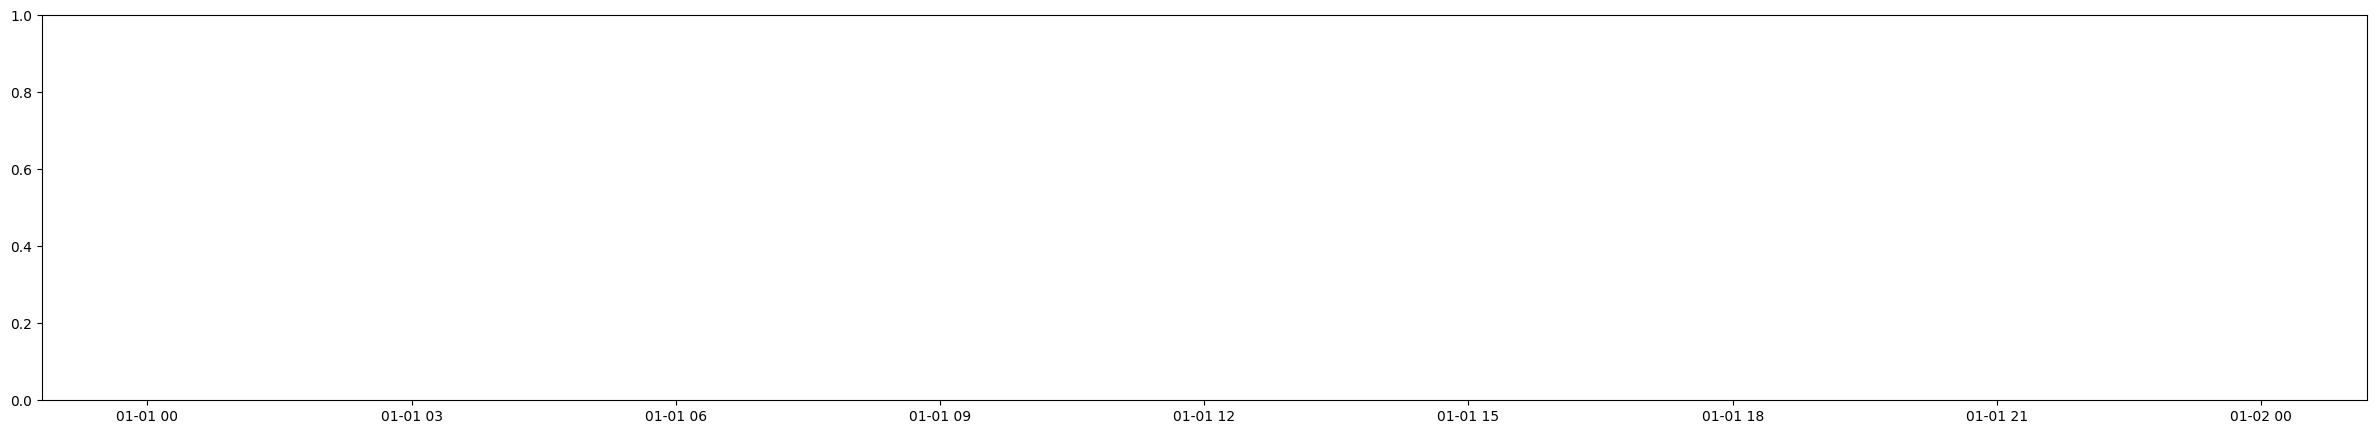

In [ ]:
x_train_imputed, original_x_train_indices = impute_na(x_train, plot=True)

COLUMN :  spot_id_delta
COLUMN :  original
Could not decompose original into trend/seasonality, doing simple interpolation


C:\Users\TRETEC\AppData\Local\Temp\ipykernel_15412\4156669124.py:57: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp[column] = df_temp[column].fillna(method = 'ffill')


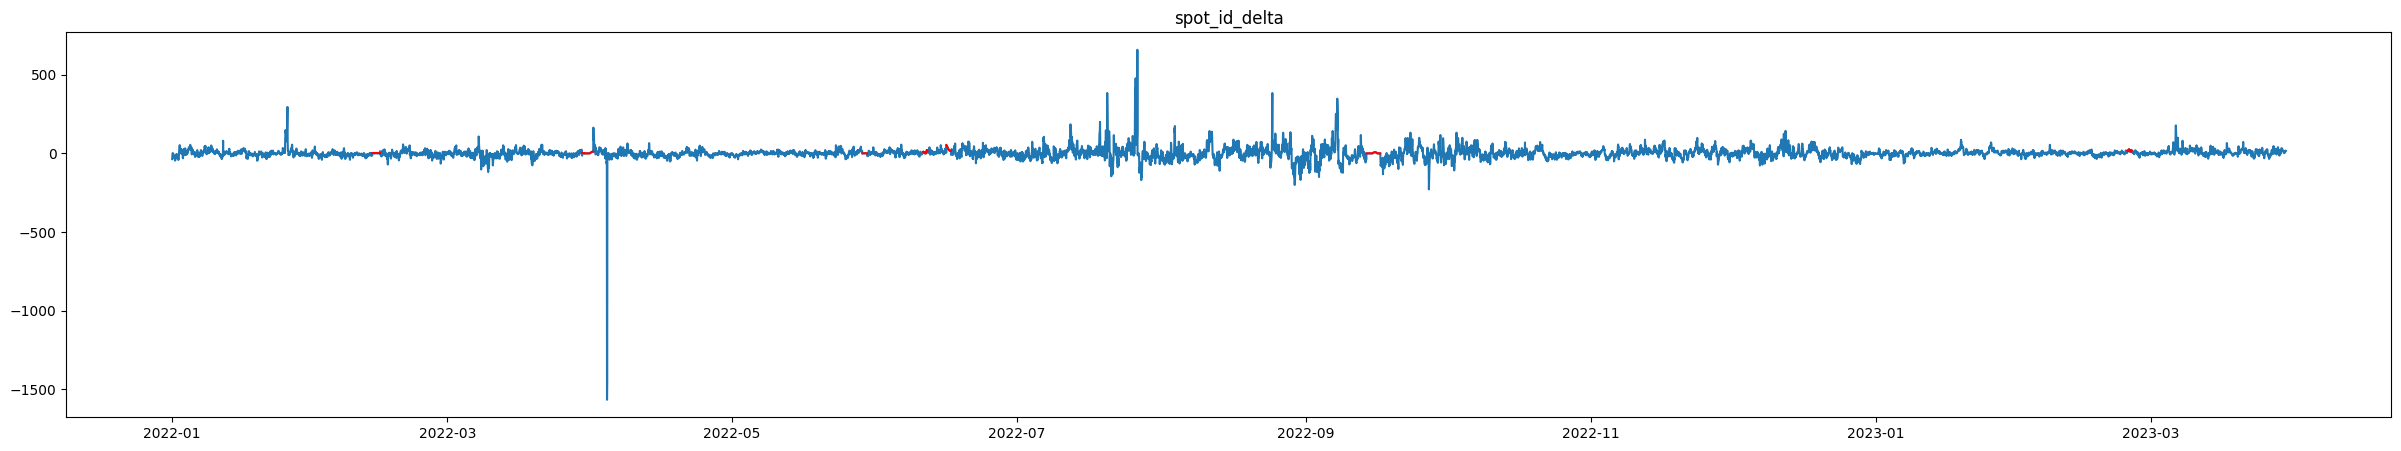

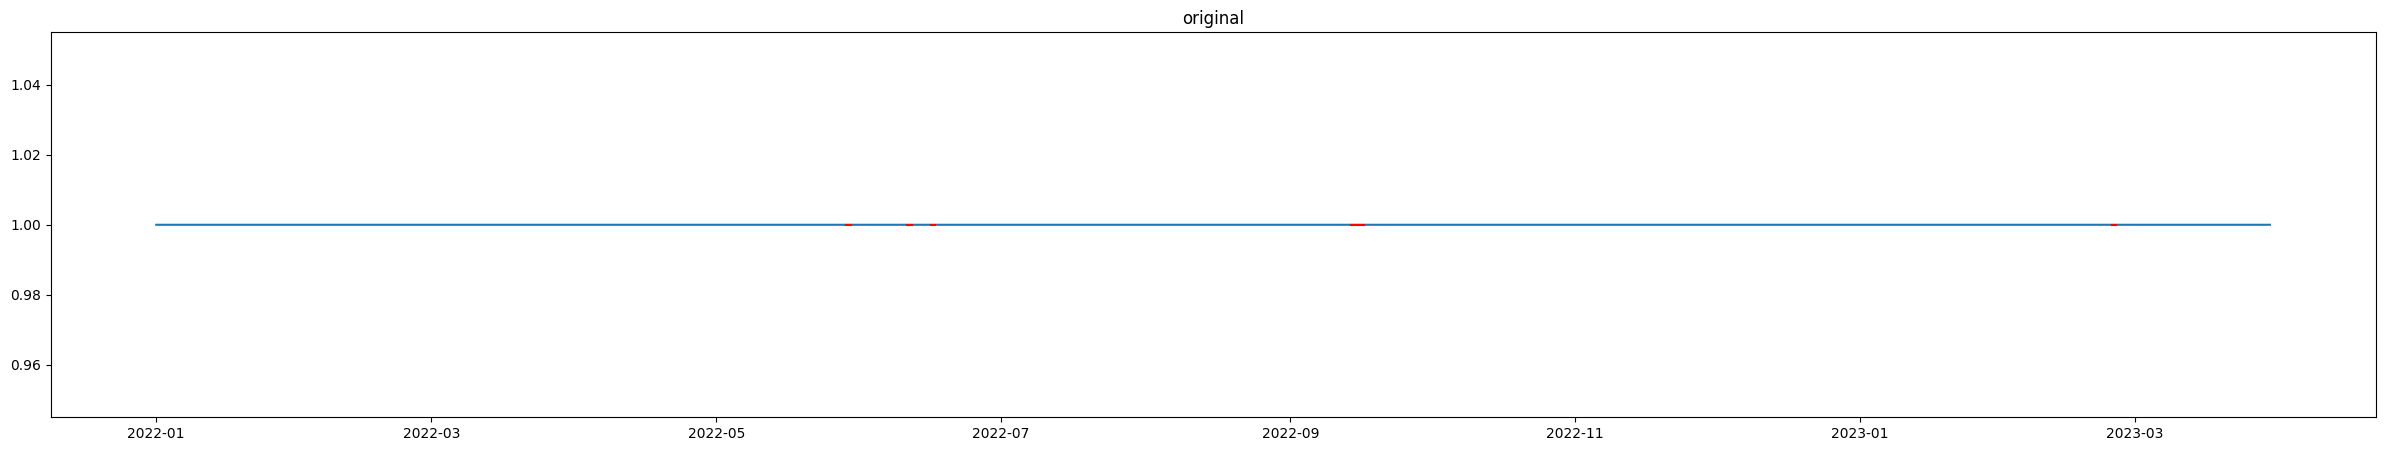

In [ ]:
y_train_imputed, original_y_train_indices = impute_na(y_train, plot=True)

In [ ]:
for i,j in zip(original_x_train_indices, original_y_train_indices):
    assert i == j

In [ ]:
x_train_imputed['conso_prod_delta'] = x_train_imputed['load_forecast']-(x_train_imputed['coal_power_available'] + x_train_imputed['gas_power_available']+ x_train_imputed['nucelear_power_available'] + x_train_imputed['solar_power_forecasts_average']+ x_train_imputed['wind_power_forecasts_average'])

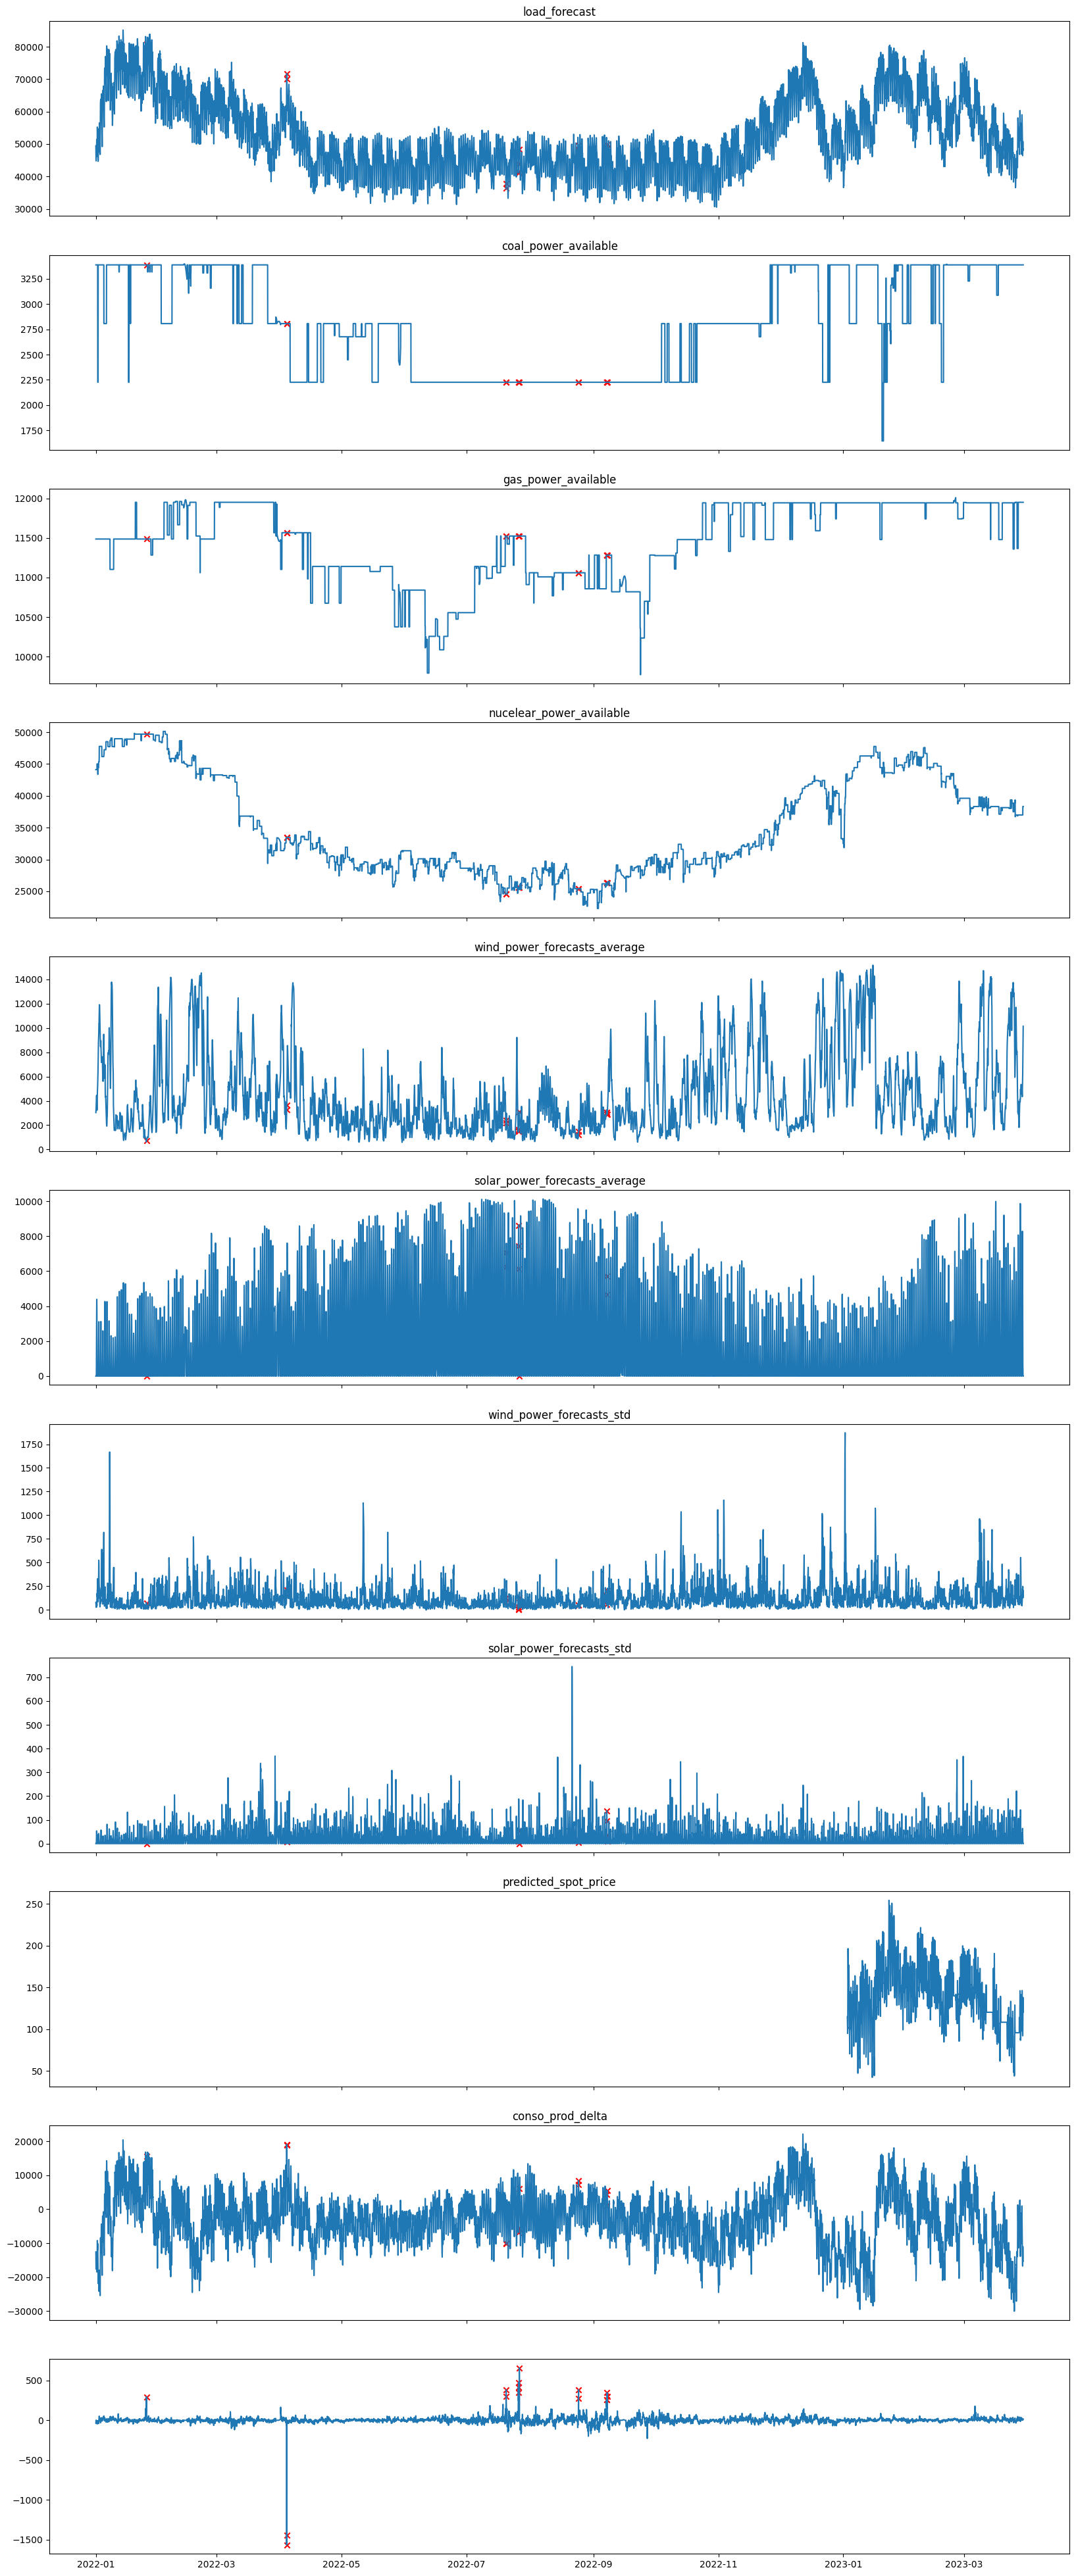

In [ ]:
f, ax = plt.subplots(len(x_train_imputed.columns)+1, 1, sharex=True, figsize=(20,50))
for i, col in enumerate(x_train_imputed.columns):    
    ax[i].plot(x_train_imputed[col])
    for date in dates:
        ax[i].scatter(date, x_train_imputed.loc[date, col], color='red', marker='x')
    ax[i].set_title(str(col))
ax[-1].plot(y_train_imputed['spot_id_delta'])
for date in dates:
    ax[-1].scatter(date, y_train_imputed.loc[date, 'spot_id_delta'], color='red', marker='x')

<Axes: >

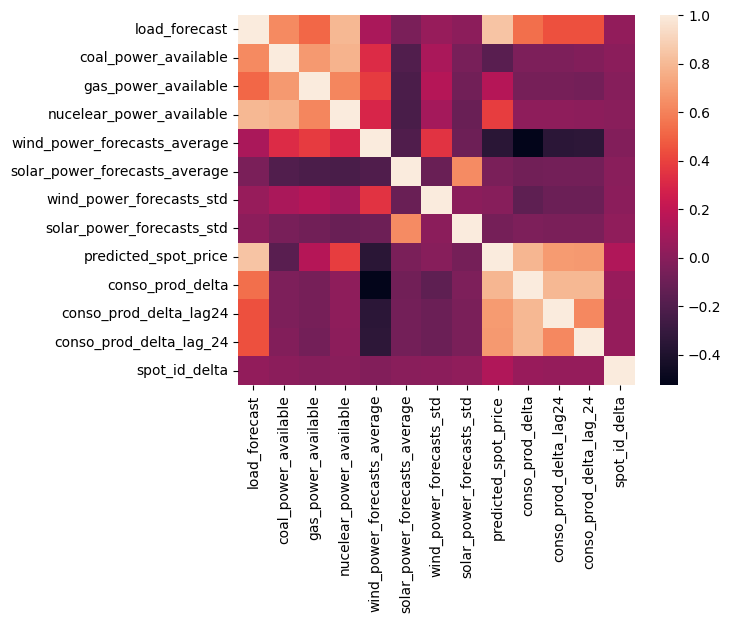

In [ ]:
x_train_imputed['conso_prod_delta_lag24'] = x_train_imputed['conso_prod_delta'].shift(24)
x_train_imputed['conso_prod_delta_lag_24'] = x_train_imputed['conso_prod_delta'].shift(-24)
data_imputed = pd.concat((x_train_imputed,y_train_imputed),axis=1)
sns.heatmap(data_imputed.corr())

# Trash

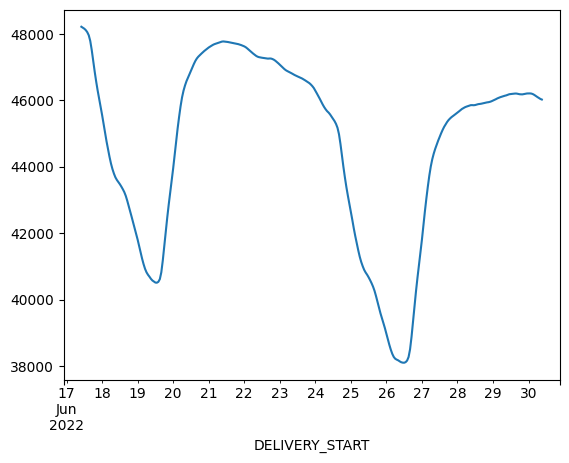

<Axes: xlabel='DELIVERY_START'>

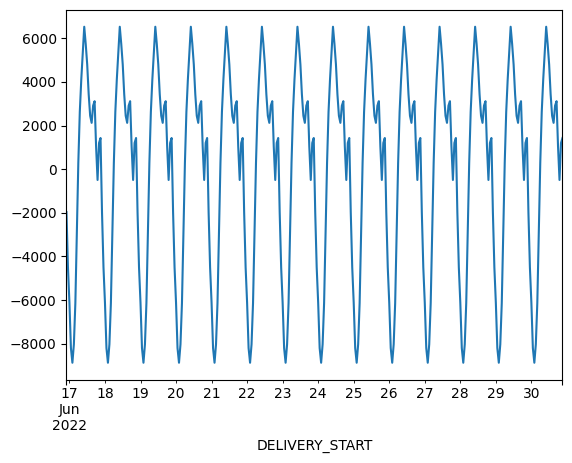

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

l1 = null_patches[longest_patch_ind-1][-1] + pd.Timedelta('1h')
l2 = null_patches[longest_patch_ind][0] - pd.Timedelta('1h')
left = x_train_copy['load_forecast'][l1:l2]

decomposition_left = seasonal_decompose(left, model='additive')
decomposition_left.trend.plot()
plt.show()
decomposition_left.seasonal.plot()

<Axes: xlabel='DELIVERY_START'>

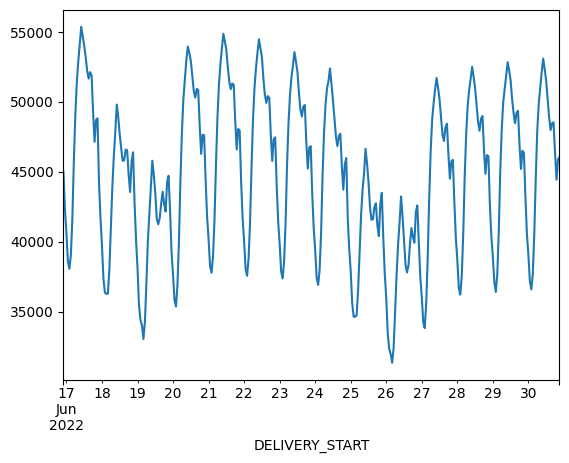

In [ ]:
signal = left
time_array = np.arange(signal.size)
signal.plot()

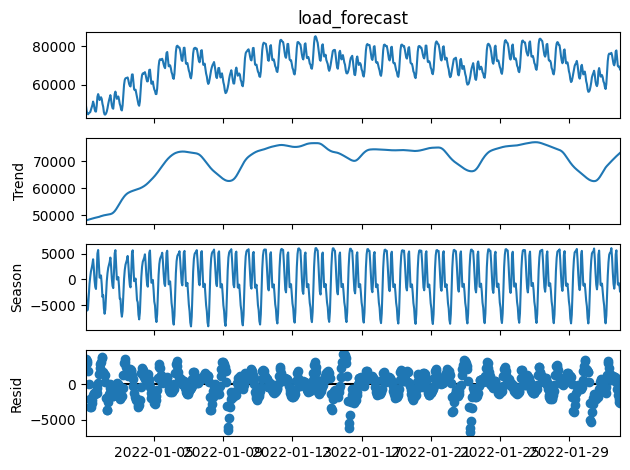

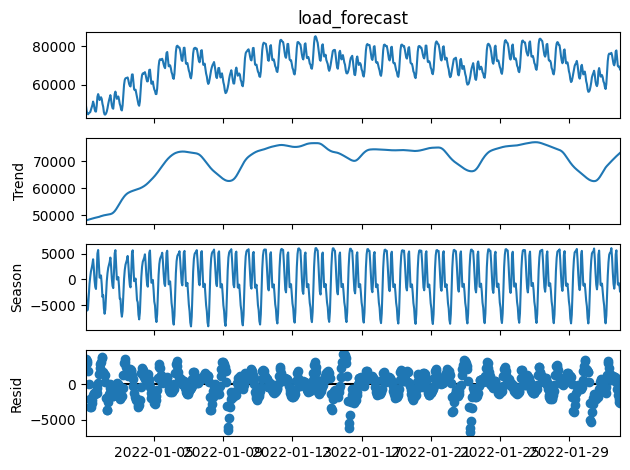

In [ ]:
from statsmodels.tsa.seasonal import STL
signal = x_train['load_forecast']['2022-01']
res = STL(signal,seasonal=13).fit()
res.plot()

In [ ]:
signal.index.freq

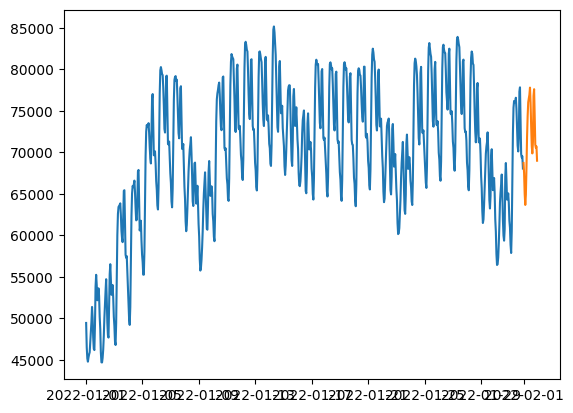

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast

signal.index.freq = signal.index.inferred_freq
stlf = STLForecast(signal, ARIMA, model_kwargs=dict(order=(1, 1, 0), trend="t"))
stlf_res = stlf.fit()

forecast = stlf_res.forecast(24)
plt.plot(signal)
plt.plot(forecast)
plt.show()

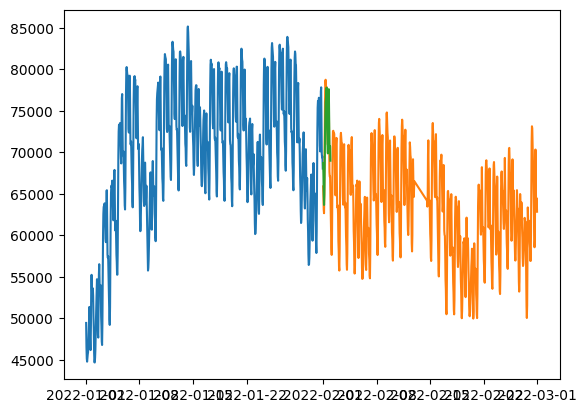

In [ ]:
plt.plot(signal)
plt.plot(x_train['load_forecast']['2022-02'])
plt.plot(forecast)

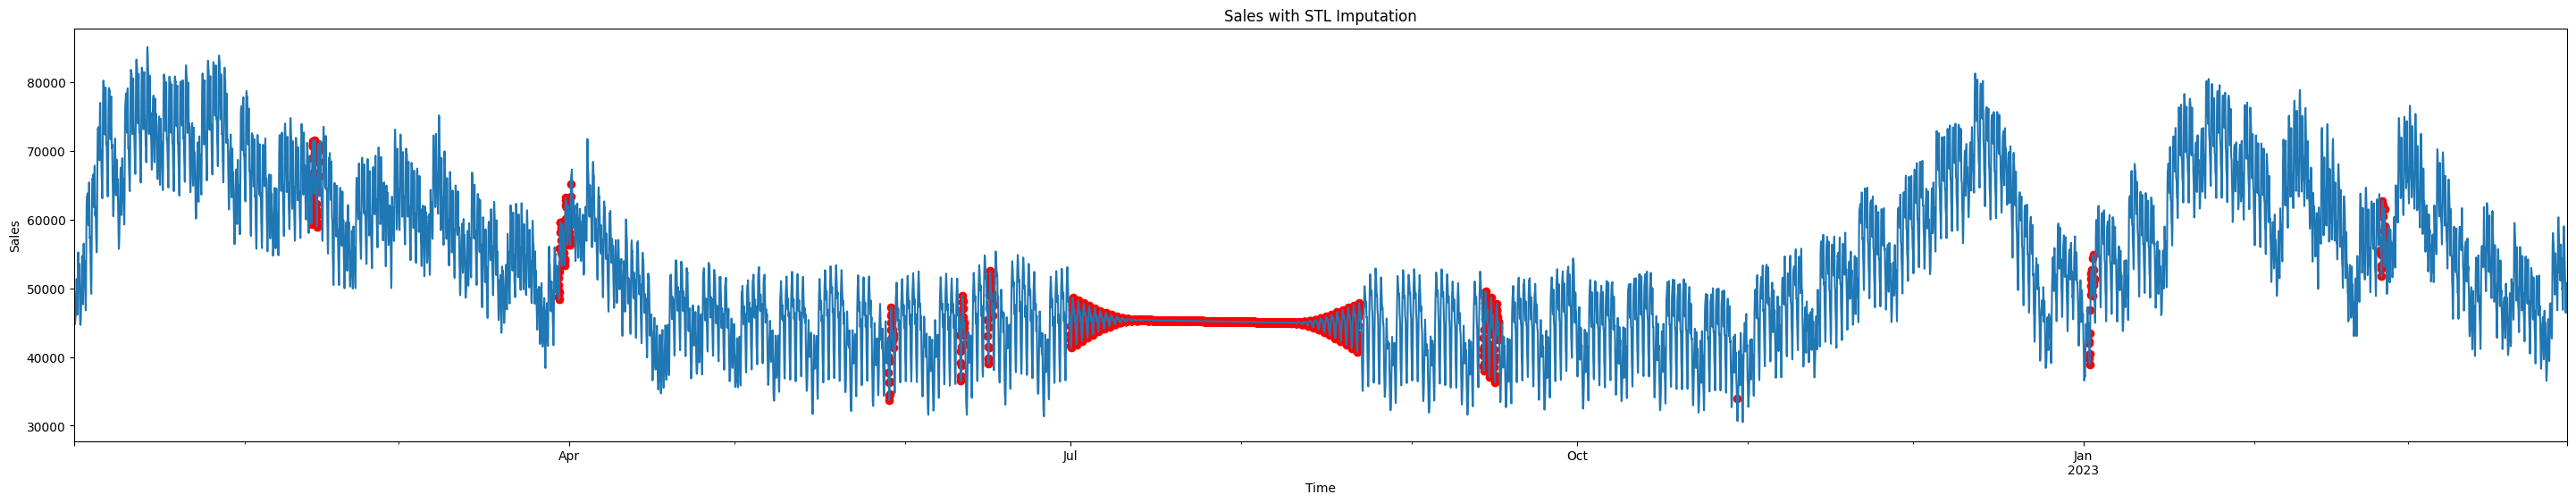

<Axes: xlabel='DELIVERY_START'>

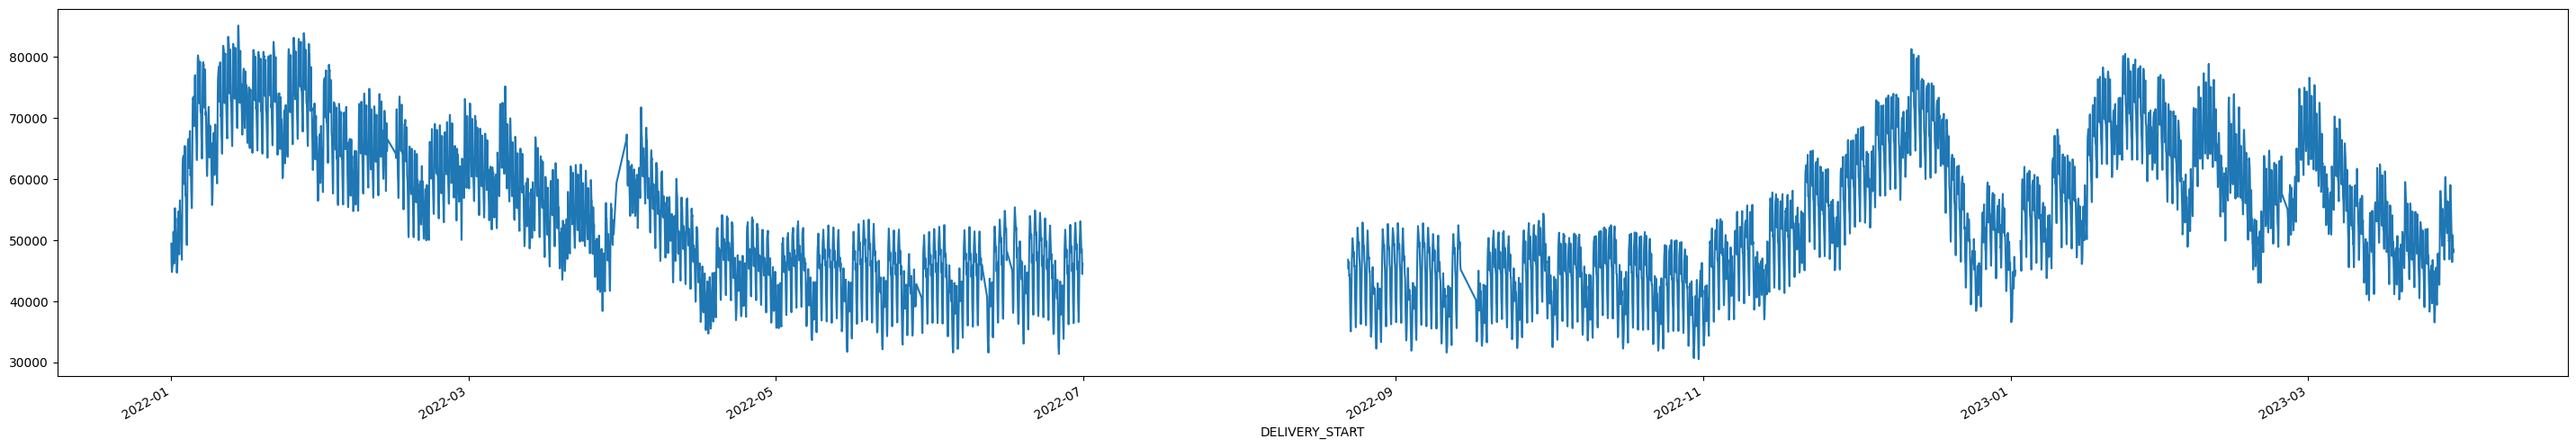

In [ ]:
# Make a copy of the original dataframe
x_train_copy = x_train.copy()

x_train_copy = x_train_copy.resample('1h').mean()

# Fill missing values in the time series
imputed_indices = x_train_copy[x_train_copy['load_forecast'].isnull()].index
# Apply STL decompostion
stl = STL(x_train_copy['load_forecast'].interpolate(), seasonal=31)
res = stl.fit()

# Extract the seasonal and trend components
seasonal_component = res.seasonal

# Create the deseasonalised series
x_train_deseasonalised = x_train_copy['load_forecast'] - seasonal_component

# Interpolate missing values in the deseasonalised series
x_train_deseasonalised_imputed = x_train_deseasonalised.interpolate(method="linear")

# Add the seasonal component back to create the final imputed series
x_train_imputed = x_train_deseasonalised_imputed + seasonal_component

# Update the original dataframe with the imputed values
x_train_copy.loc[imputed_indices, 'load_forecast'] = x_train_imputed[imputed_indices]

# Plot the series using pandas
plt.figure(figsize=[36, 6])
x_train_copy['load_forecast'].plot(label='load_forecast')
plt.scatter(imputed_indices, x_train_copy.loc[imputed_indices, 'load_forecast'], color='red')

plt.title("Sales with STL Imputation")
plt.ylabel("Sales")
plt.xlabel("Time")
plt.show()
plt.figure(figsize=[36, 6])
x_train['load_forecast'].plot()
